In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import special, stats

from utils import (
    cholesky_from_svd,
    coef_indicator_pce,
    cov_indicator_pce,
    indicator_pce,
    mean_cov_pce_quad,
    mean_indicator_pce,
)

SEED = 1234

sns.set_theme()
sns.set_context("notebook", font_scale=1.5)

# 1. Plot of $x \mapsto e^{\frac{-x^2}{2}}\: |\mathrm{He}_n(x)|$

In [4]:
def func_one(n, x):
    """
    Compute exp(-x^2/2) * | He_n(x) | where He_n(x) is the n-th
    probabilists' Hermite polynomial.
    """
    return np.exp(-0.5 * x**2) * np.abs(special.hermitenorm(n)(x))

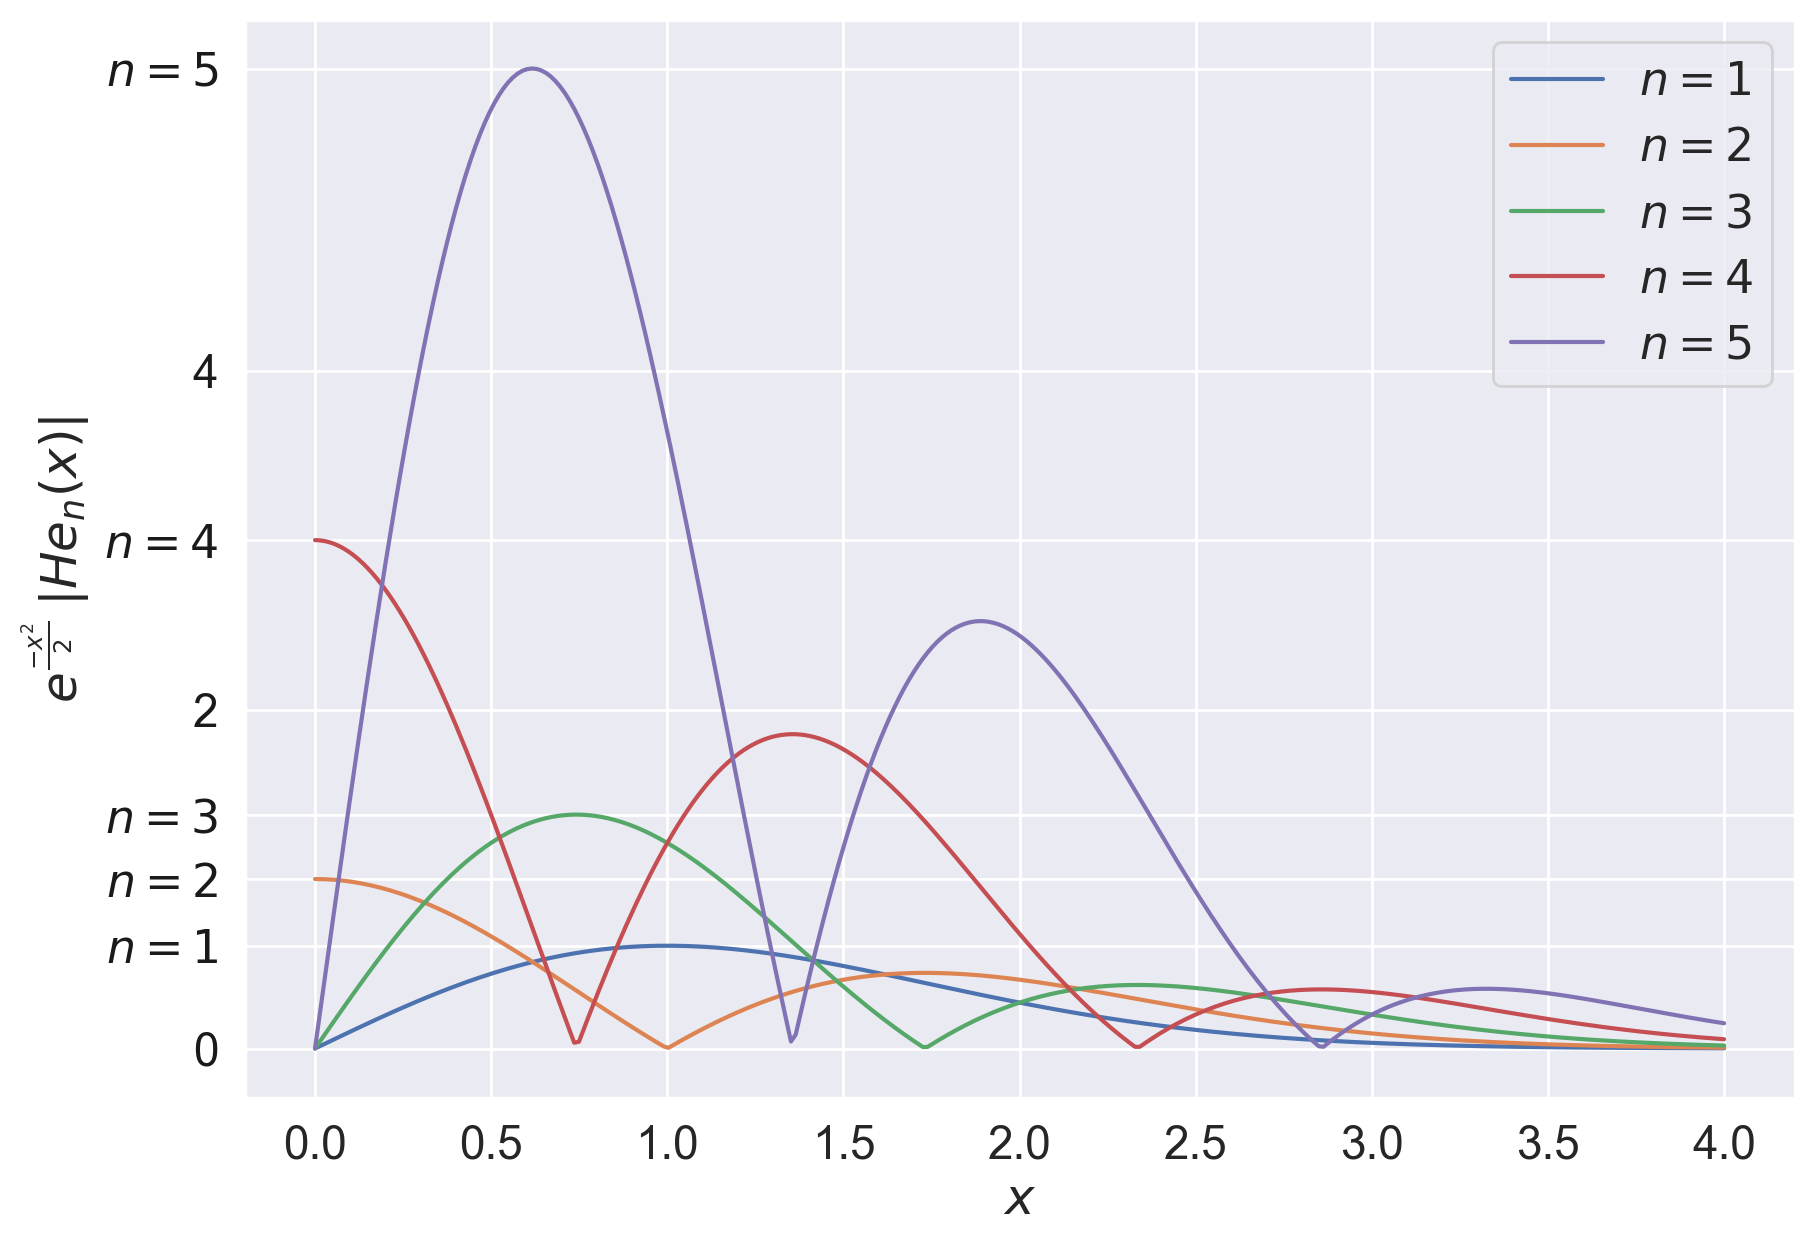

In [5]:
n = 6
x = np.linspace(0, 4, 300)
idx = []
max_func = []

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(1, n):
    func_i = func_one(i, x)
    idx.append(x[np.argmax(func_i)])
    max_func.append(np.max(func_i))
    ax.plot(x, func_i, label=f"$n = {i}$")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$e^{\\frac{-x^2}{2}}\\: |He_n(x)|$")
ax.set_yticks(
    [0, 2, 4] + max_func[:5],
    labels=["0", "2", "4"] + [f"$n={i + 1}$" for i in range(5)],
    color="k",
)
plt.show()

# 2. Plot of $x \mapsto \frac{e^{-x^2} \mathrm{He}_n(x)^2}{(n+1)!}$

In [6]:
def func_two(n, x):
    """
    Compute exp(-x^2) * He_n(x)^2 / (n+1)! where He_n(x) is the n-th
    probabilists' Hermite polynomial.
    """
    return np.exp(-(x**2)) * special.hermitenorm(n)(x) ** 2 / special.factorial(n + 1)

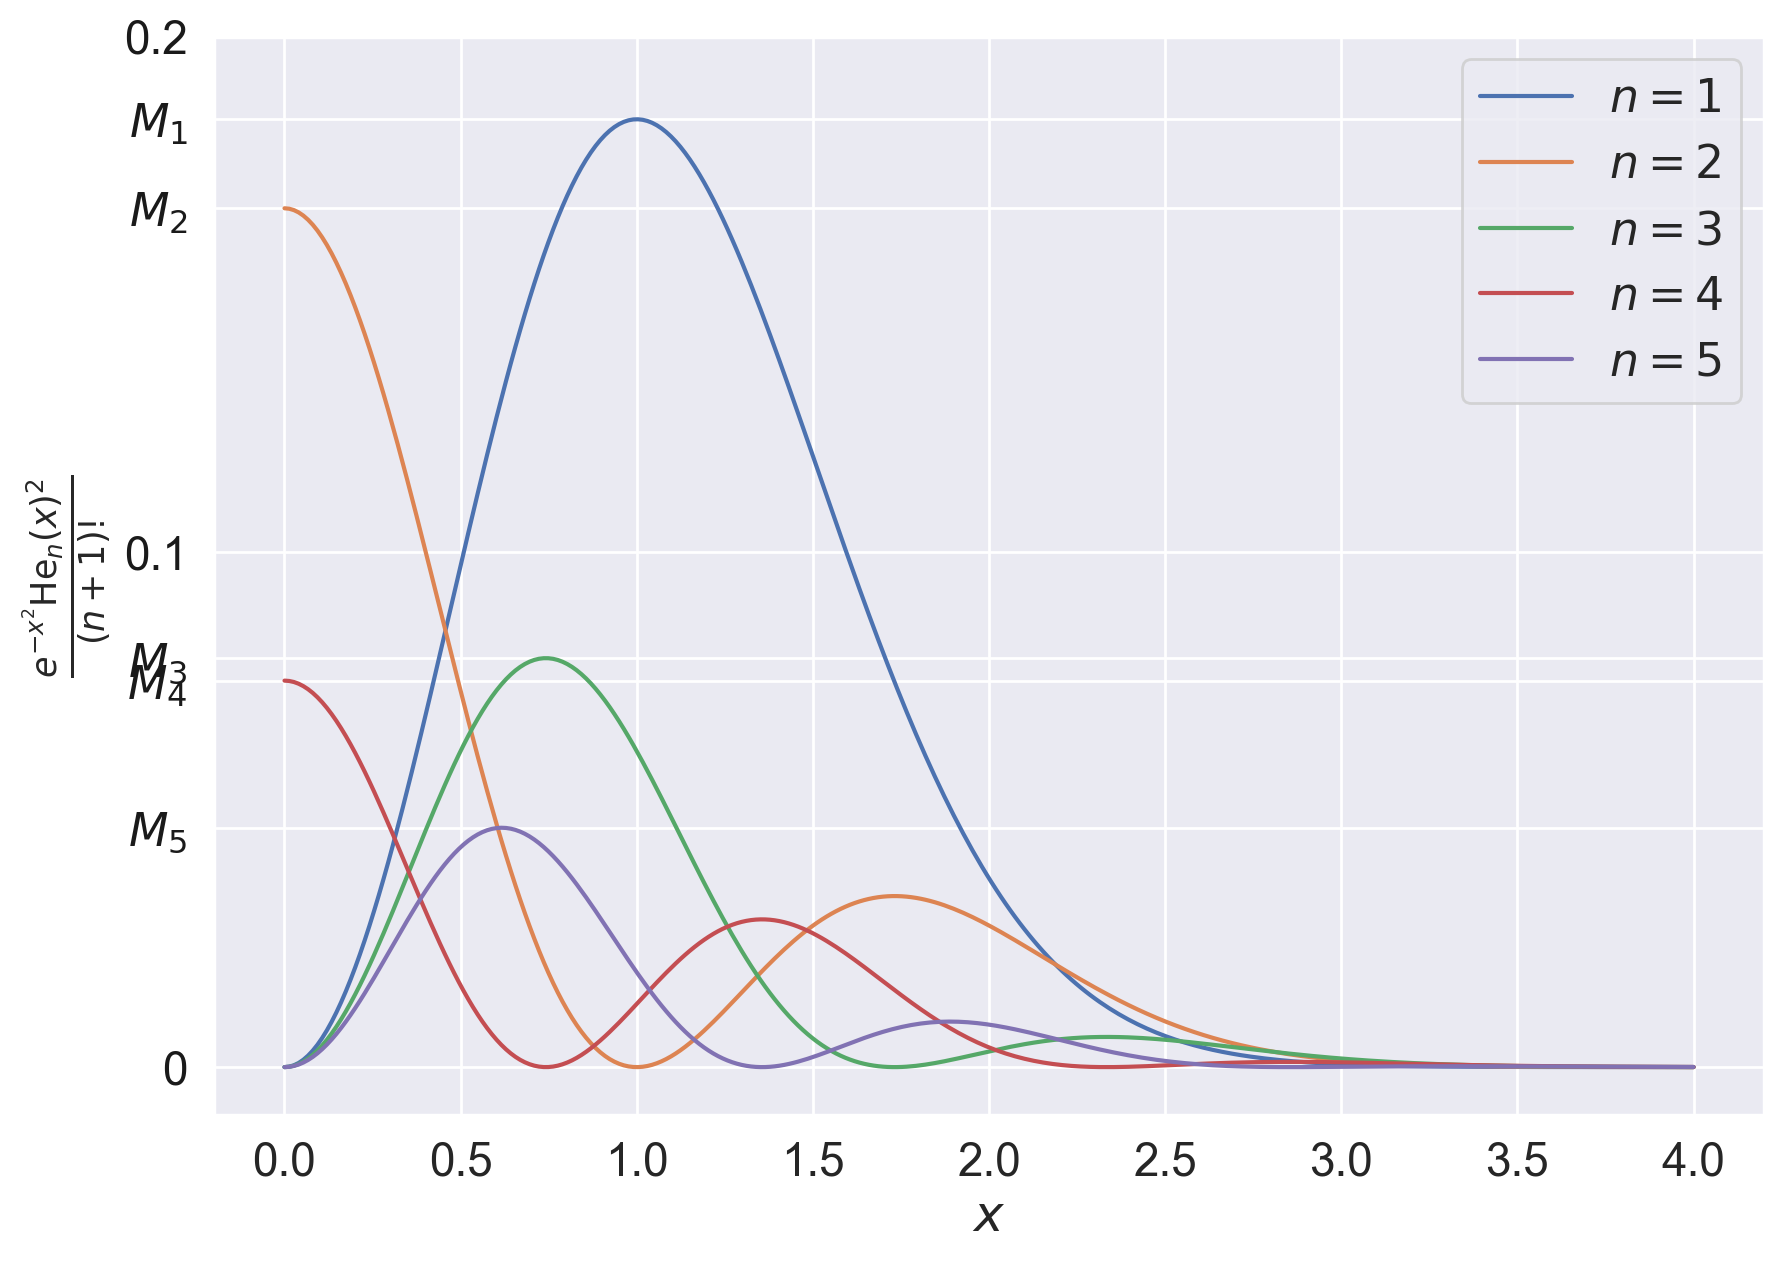

In [7]:
n = 6
x = np.linspace(0, 4, 300)
idx = []
max_zn2 = []

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(1, n):
    func_i = func_two(n=i, x=x)
    idx.append(x[np.argmax(func_i)])
    max_zn2.append(np.max(func_i))
    ax.plot(x, func_i, label=f"$n = {i}$")

ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel(r"$\frac{e^{-x^2} \mathrm{He}_n(x)^2}{(n+1)!}$")
ax.set_yticks(
    [0, 0.1, 0.2] + max_zn2[:5],
    labels=["0", "0.1", "0.2"] + [f"$M_{{{i + 1}}}$" for i in range(5)],
    color="k",
)
plt.show()

# 3. Study of $a_k$ and $b_k$ coefficients

Recall that for every $k \in \{1,\ldots,K\}$,

$$
    a_k = -\frac{\sqrt{1-\rho_k^2}}{|\rho_k|},
    \quad
    b_k = -\frac{\Phi^{-1}(p_k)}{|\rho_k|}.
$$

In [8]:
# Define the grid
p = np.linspace(0.01, 0.1, 100)
rho = np.linspace(0.01, 0.1, 100)

# Compute the values of b
rho_grid, p_grid = np.meshgrid(rho, p)

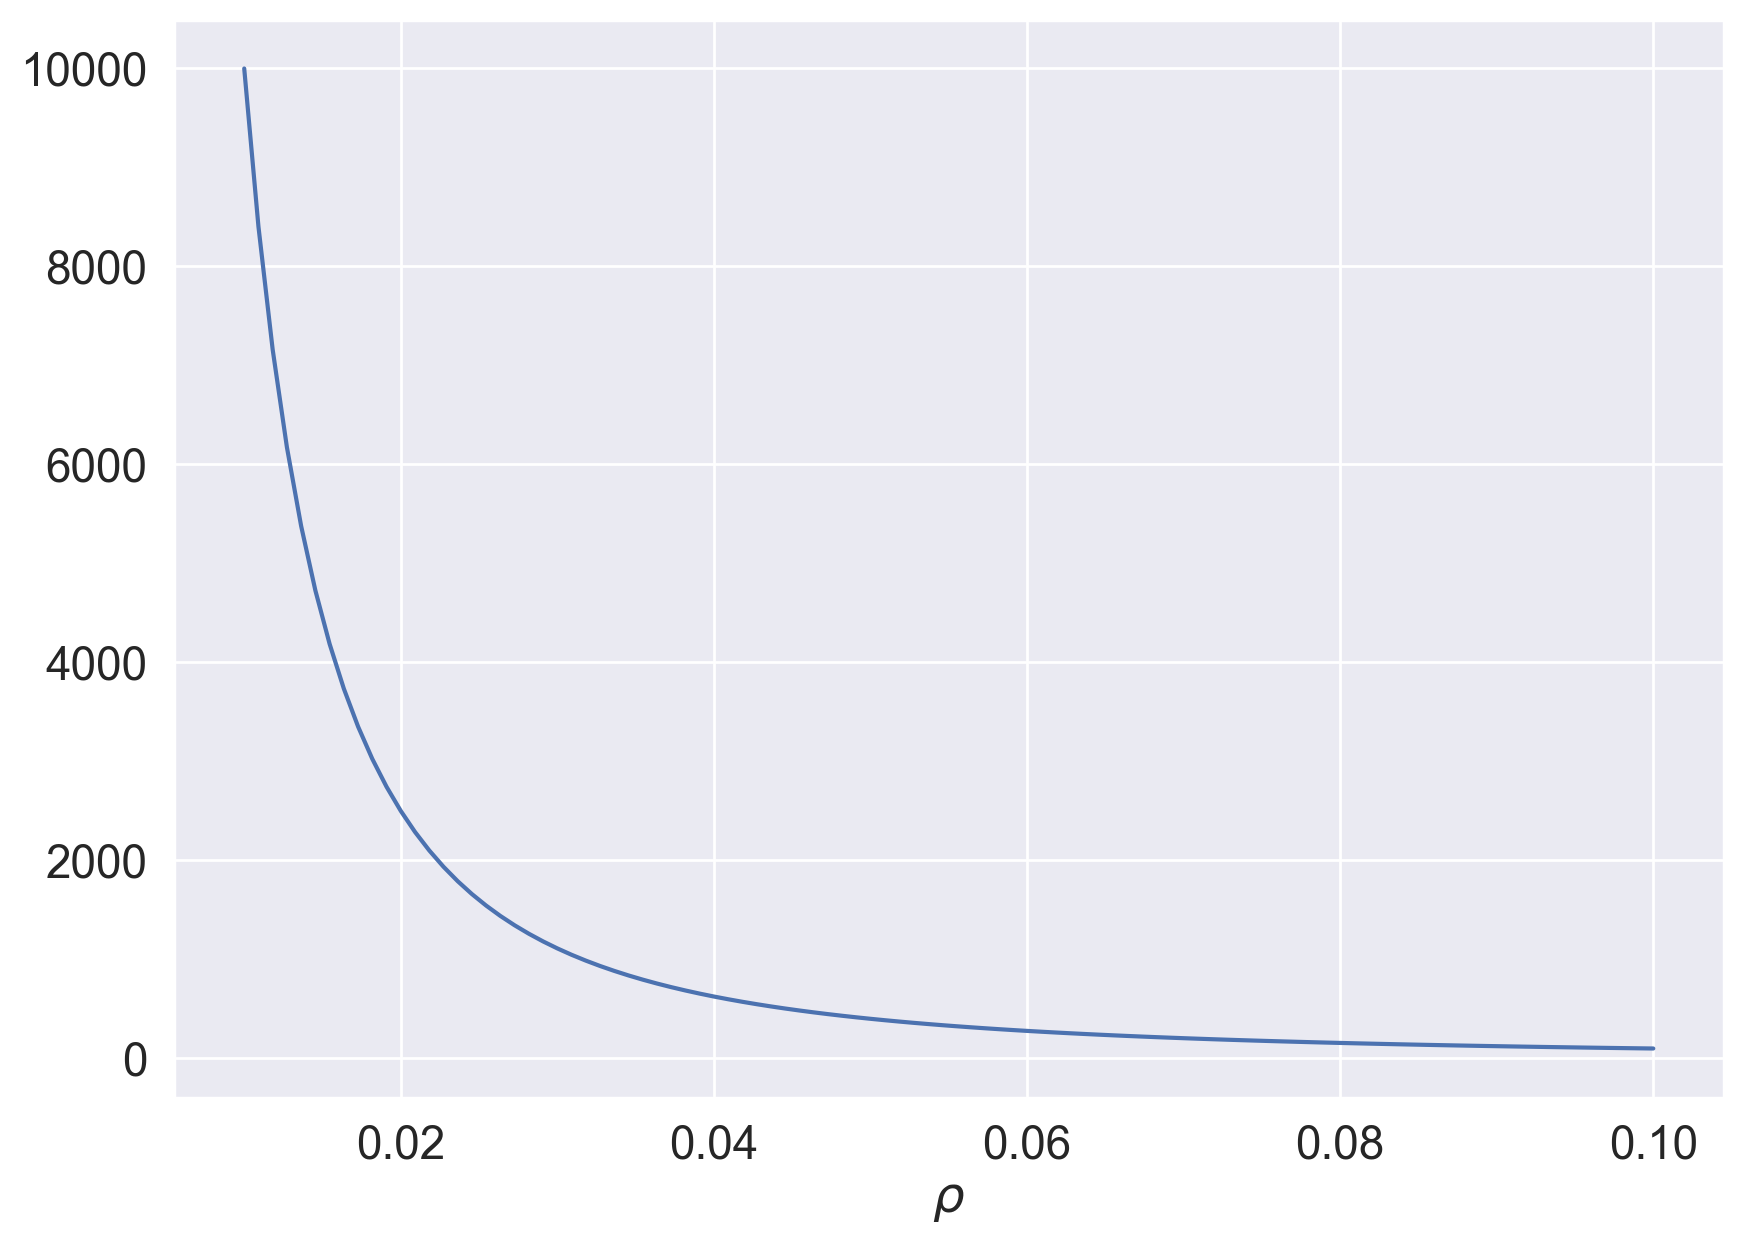

In [9]:
# Plot of rho -> (1-rho^2) / rho^2
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(rho, (1 - rho**2) / rho**2)
ax.set_xlabel(r"$\rho$")
plt.show()

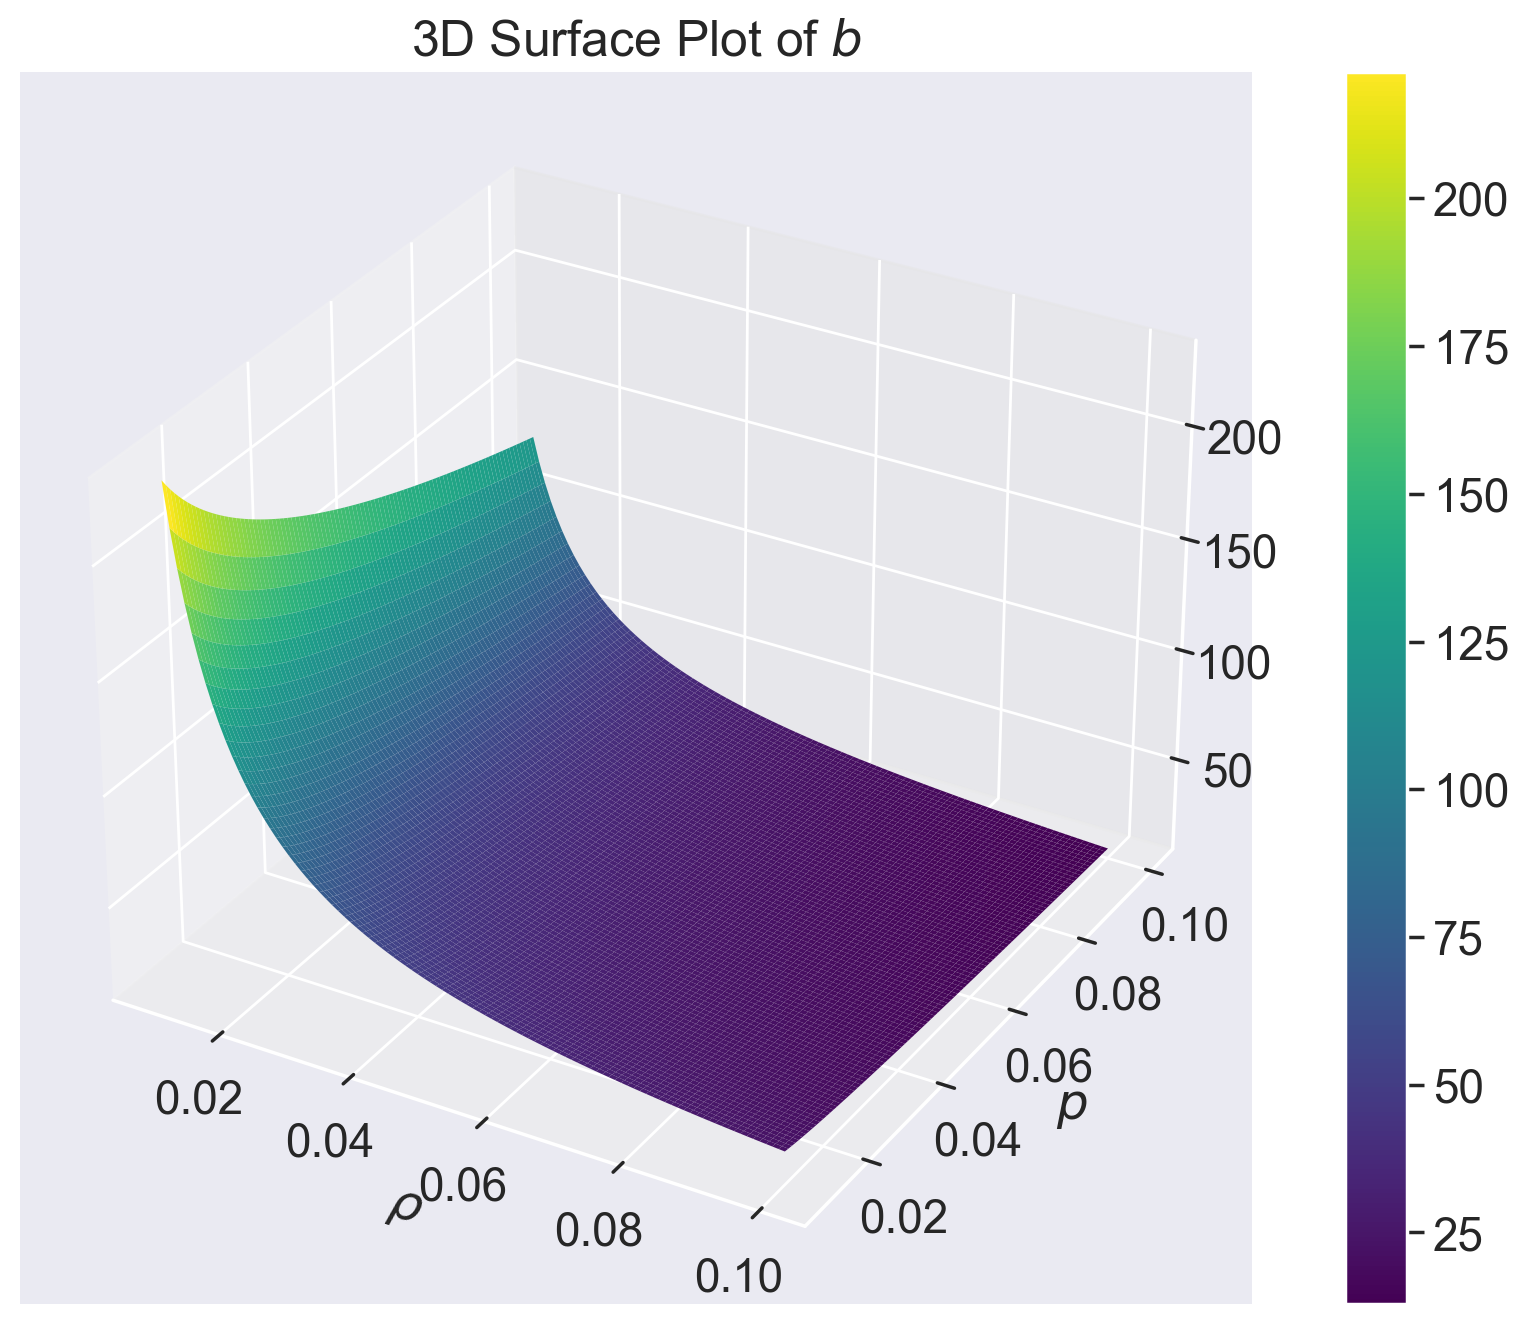

In [10]:
# Plot of (rho, p) -> -Phi^{-1}(p) / rho
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection="3d")

# Plot the surface
surface = ax.plot_surface(
    rho_grid,
    p_grid,
    -stats.norm.ppf(p_grid) / rho_grid,
    rstride=1,
    cstride=1,
    cmap=cm.viridis,
    edgecolor="none",
)

# Add a color bar
plt.colorbar(surface, ax=ax)

# Add labels and title
ax.set_title("3D Surface Plot of $b$")
ax.set_xlabel("$\\rho$")
ax.set_ylabel("$p$")

plt.show()

# 4. PCE of indicator function

$I$-chaos decompositions for $c\leq Z$ with $I \in \{ 5,20,50,80\}$ 
and $c\in \{-1,0,1,2\}$ .

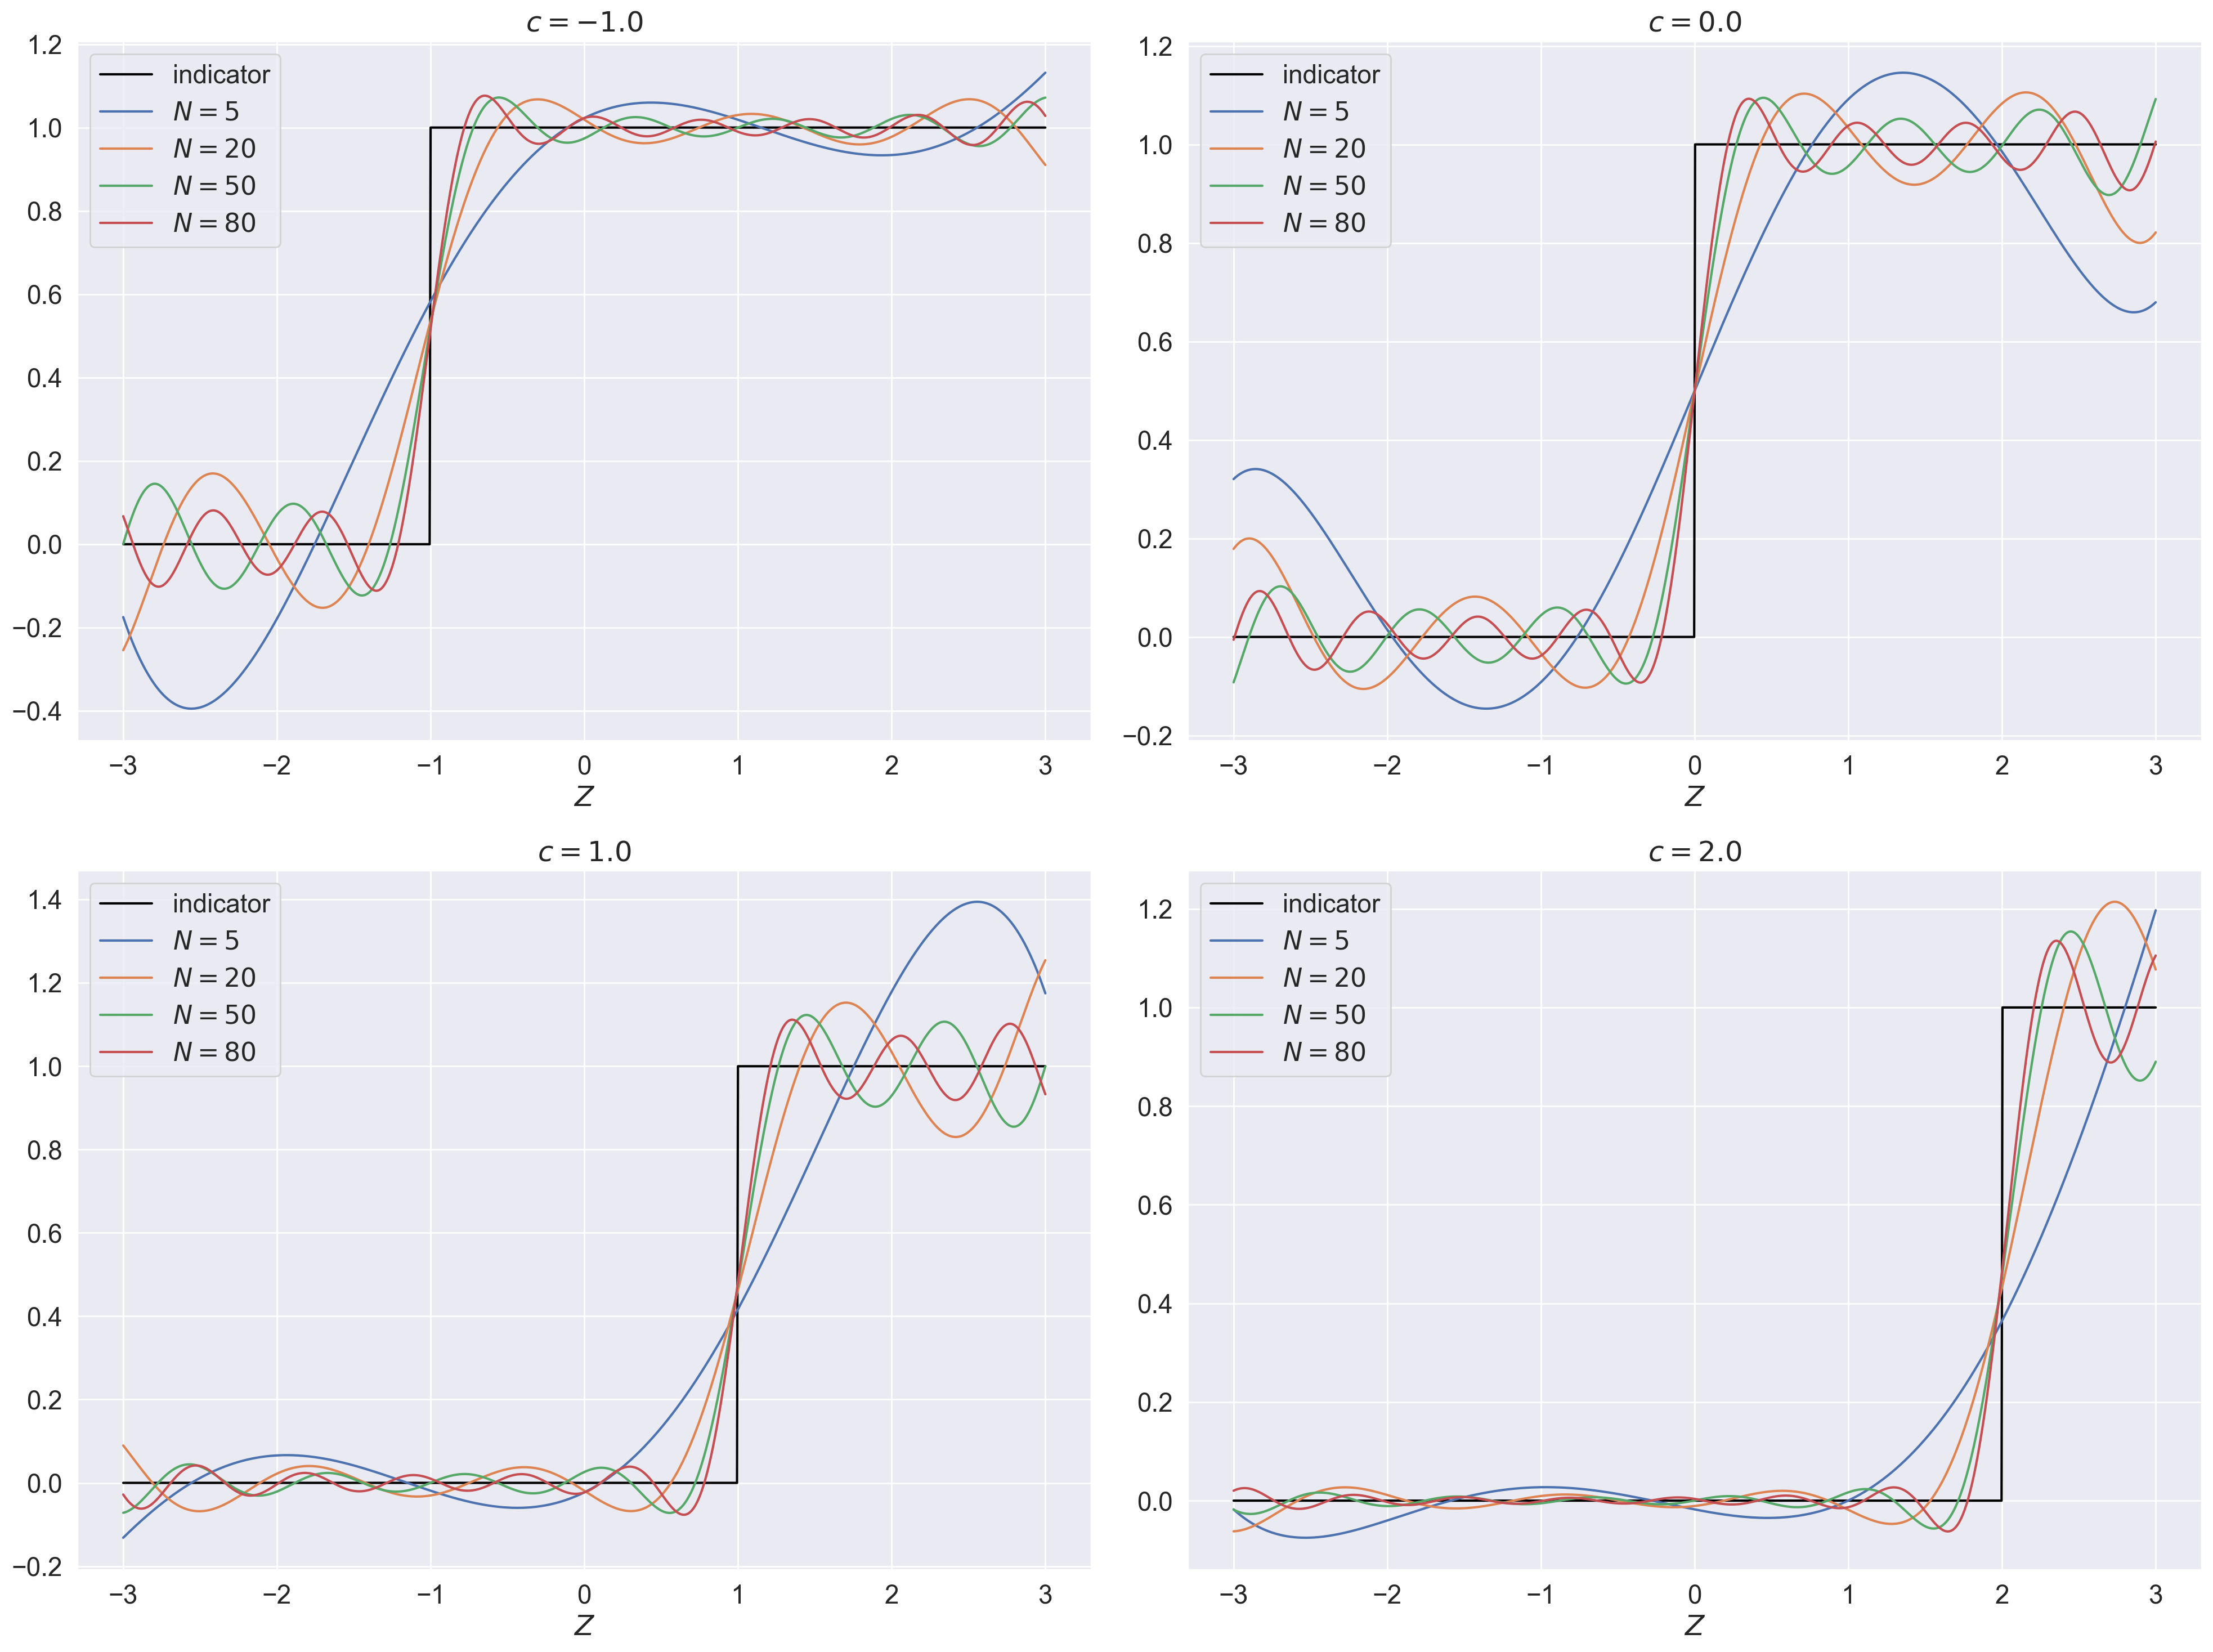

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

range_i = [5, 20, 50, 80]
z = np.linspace(start=-3, stop=3, num=10**3)
tab_c = np.array([-1.0, 0.0, 1.0, 2.0])

for c, ax in zip(tab_c, axes, strict=True):
    ind_c = 1.0 * (c <= z)
    ax.plot(z, ind_c, color="black", label="indicator")
    for i in range_i:
        ax.plot(z, indicator_pce(c, z=z, n_pce=i), label=f"$N = {i}$")
    ax.legend()
    ax.set_title(f"$c = {c}$")
    ax.set_xlabel("$Z$")

plt.tight_layout()
plt.show()

$I$-chaos decompositions for $0\leq Z$ with $I \in \{ 5,20,50,80\}$ to illustrate extreme amplitudes in the tails.

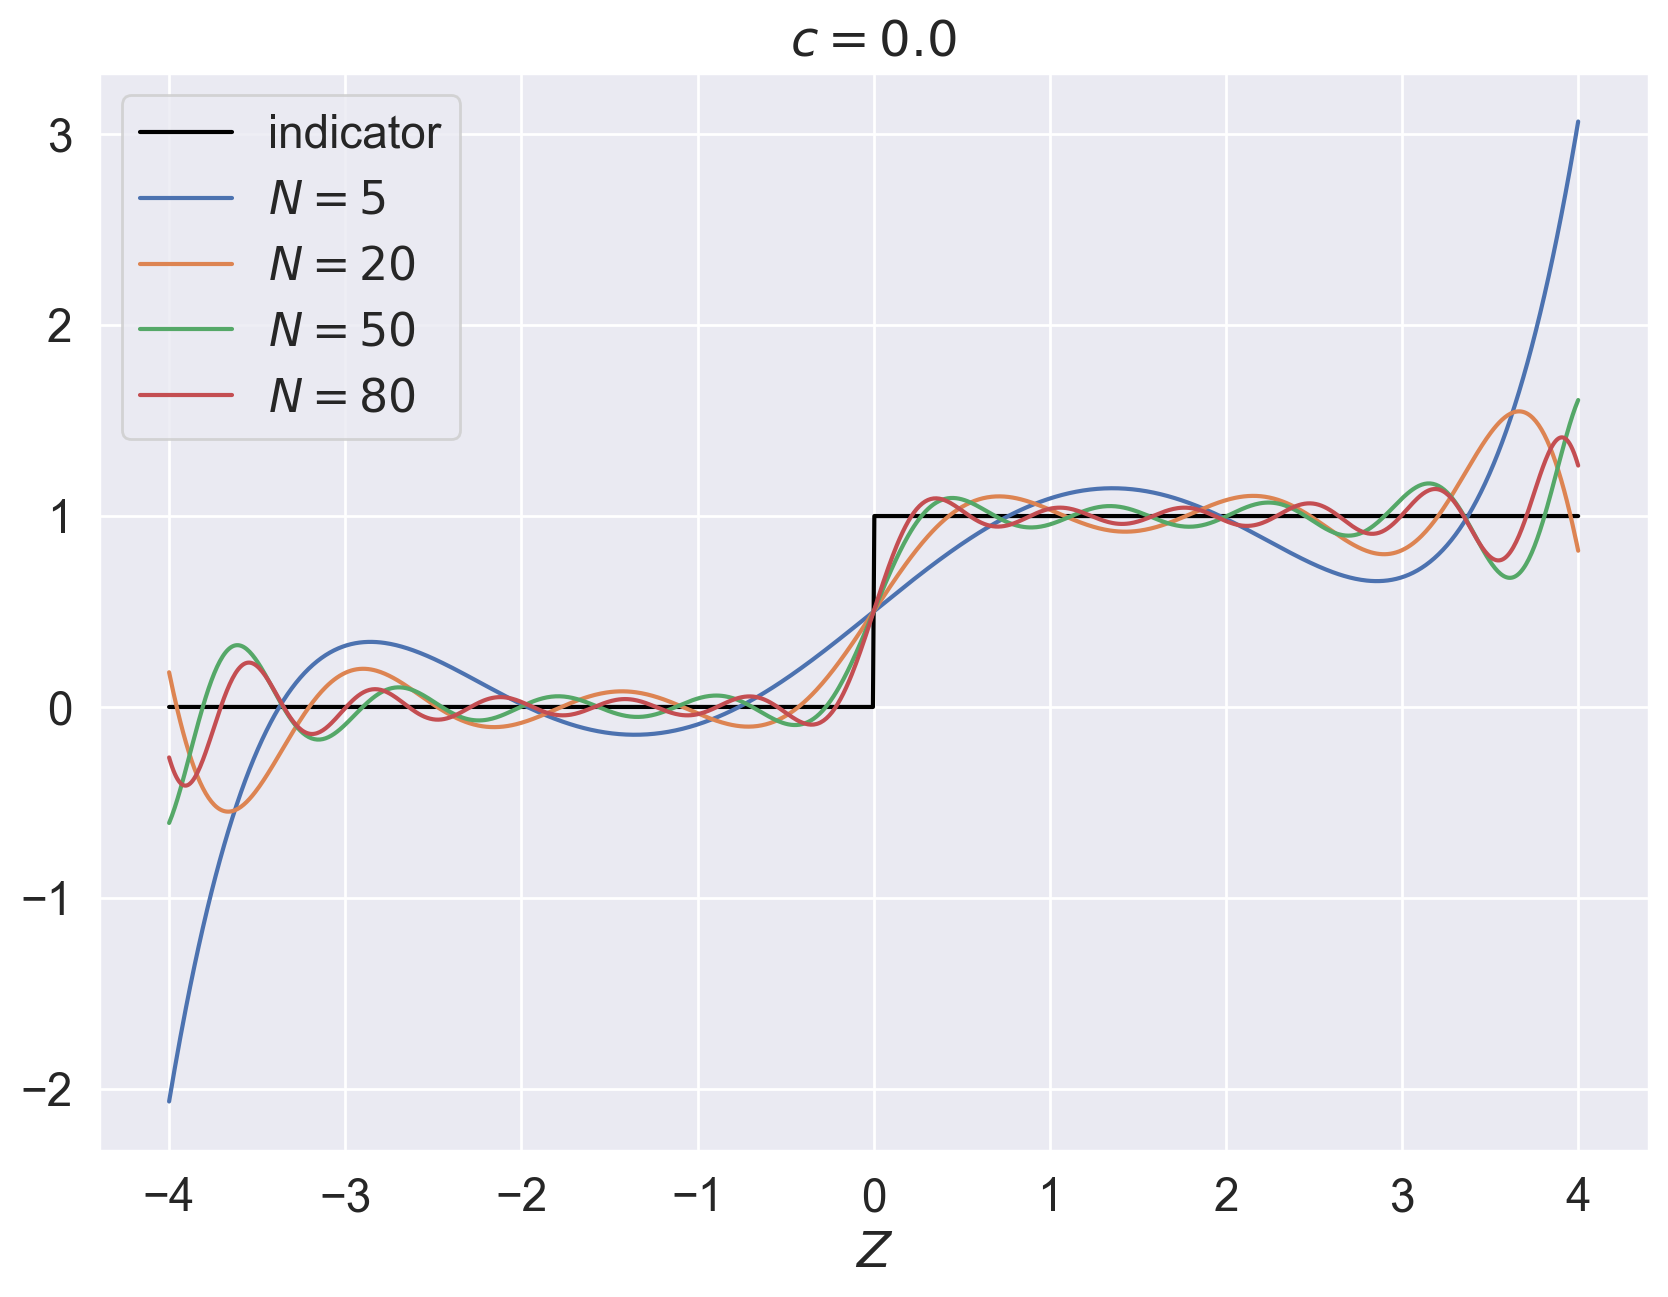

In [12]:
c = 0.0
z = np.linspace(start=-4, stop=4, num=10**3)

fig, ax = plt.subplots(figsize=(10, 7))
ind_c = 1.0 * (c <= z)
ax.plot(z, ind_c, color="black", label="indicator")
for i in range_i:
    ax.plot(z, indicator_pce(c, z=z, n_pce=i), label=f"$N = {i}$")
ax.legend()
ax.set_title(f"$c = {c}$")
ax.set_xlabel("$Z$")
plt.show()

# 5. Study of the L2 error

$\log \bigl( \mathbb{E} \bigl[ | 1_{c \leq Z} - \sum_{i=0}^{I}
\alpha_{i}(c) \mathrm{He}_i(Z)|^2\bigr] \bigr)$ with respect to $\log(I)$ for $c\in \{-1,0,1,2\}$.

We do it by Monte Carlo.

c =  -1.0
c =  0.0
c =  1.0
c =  2.0


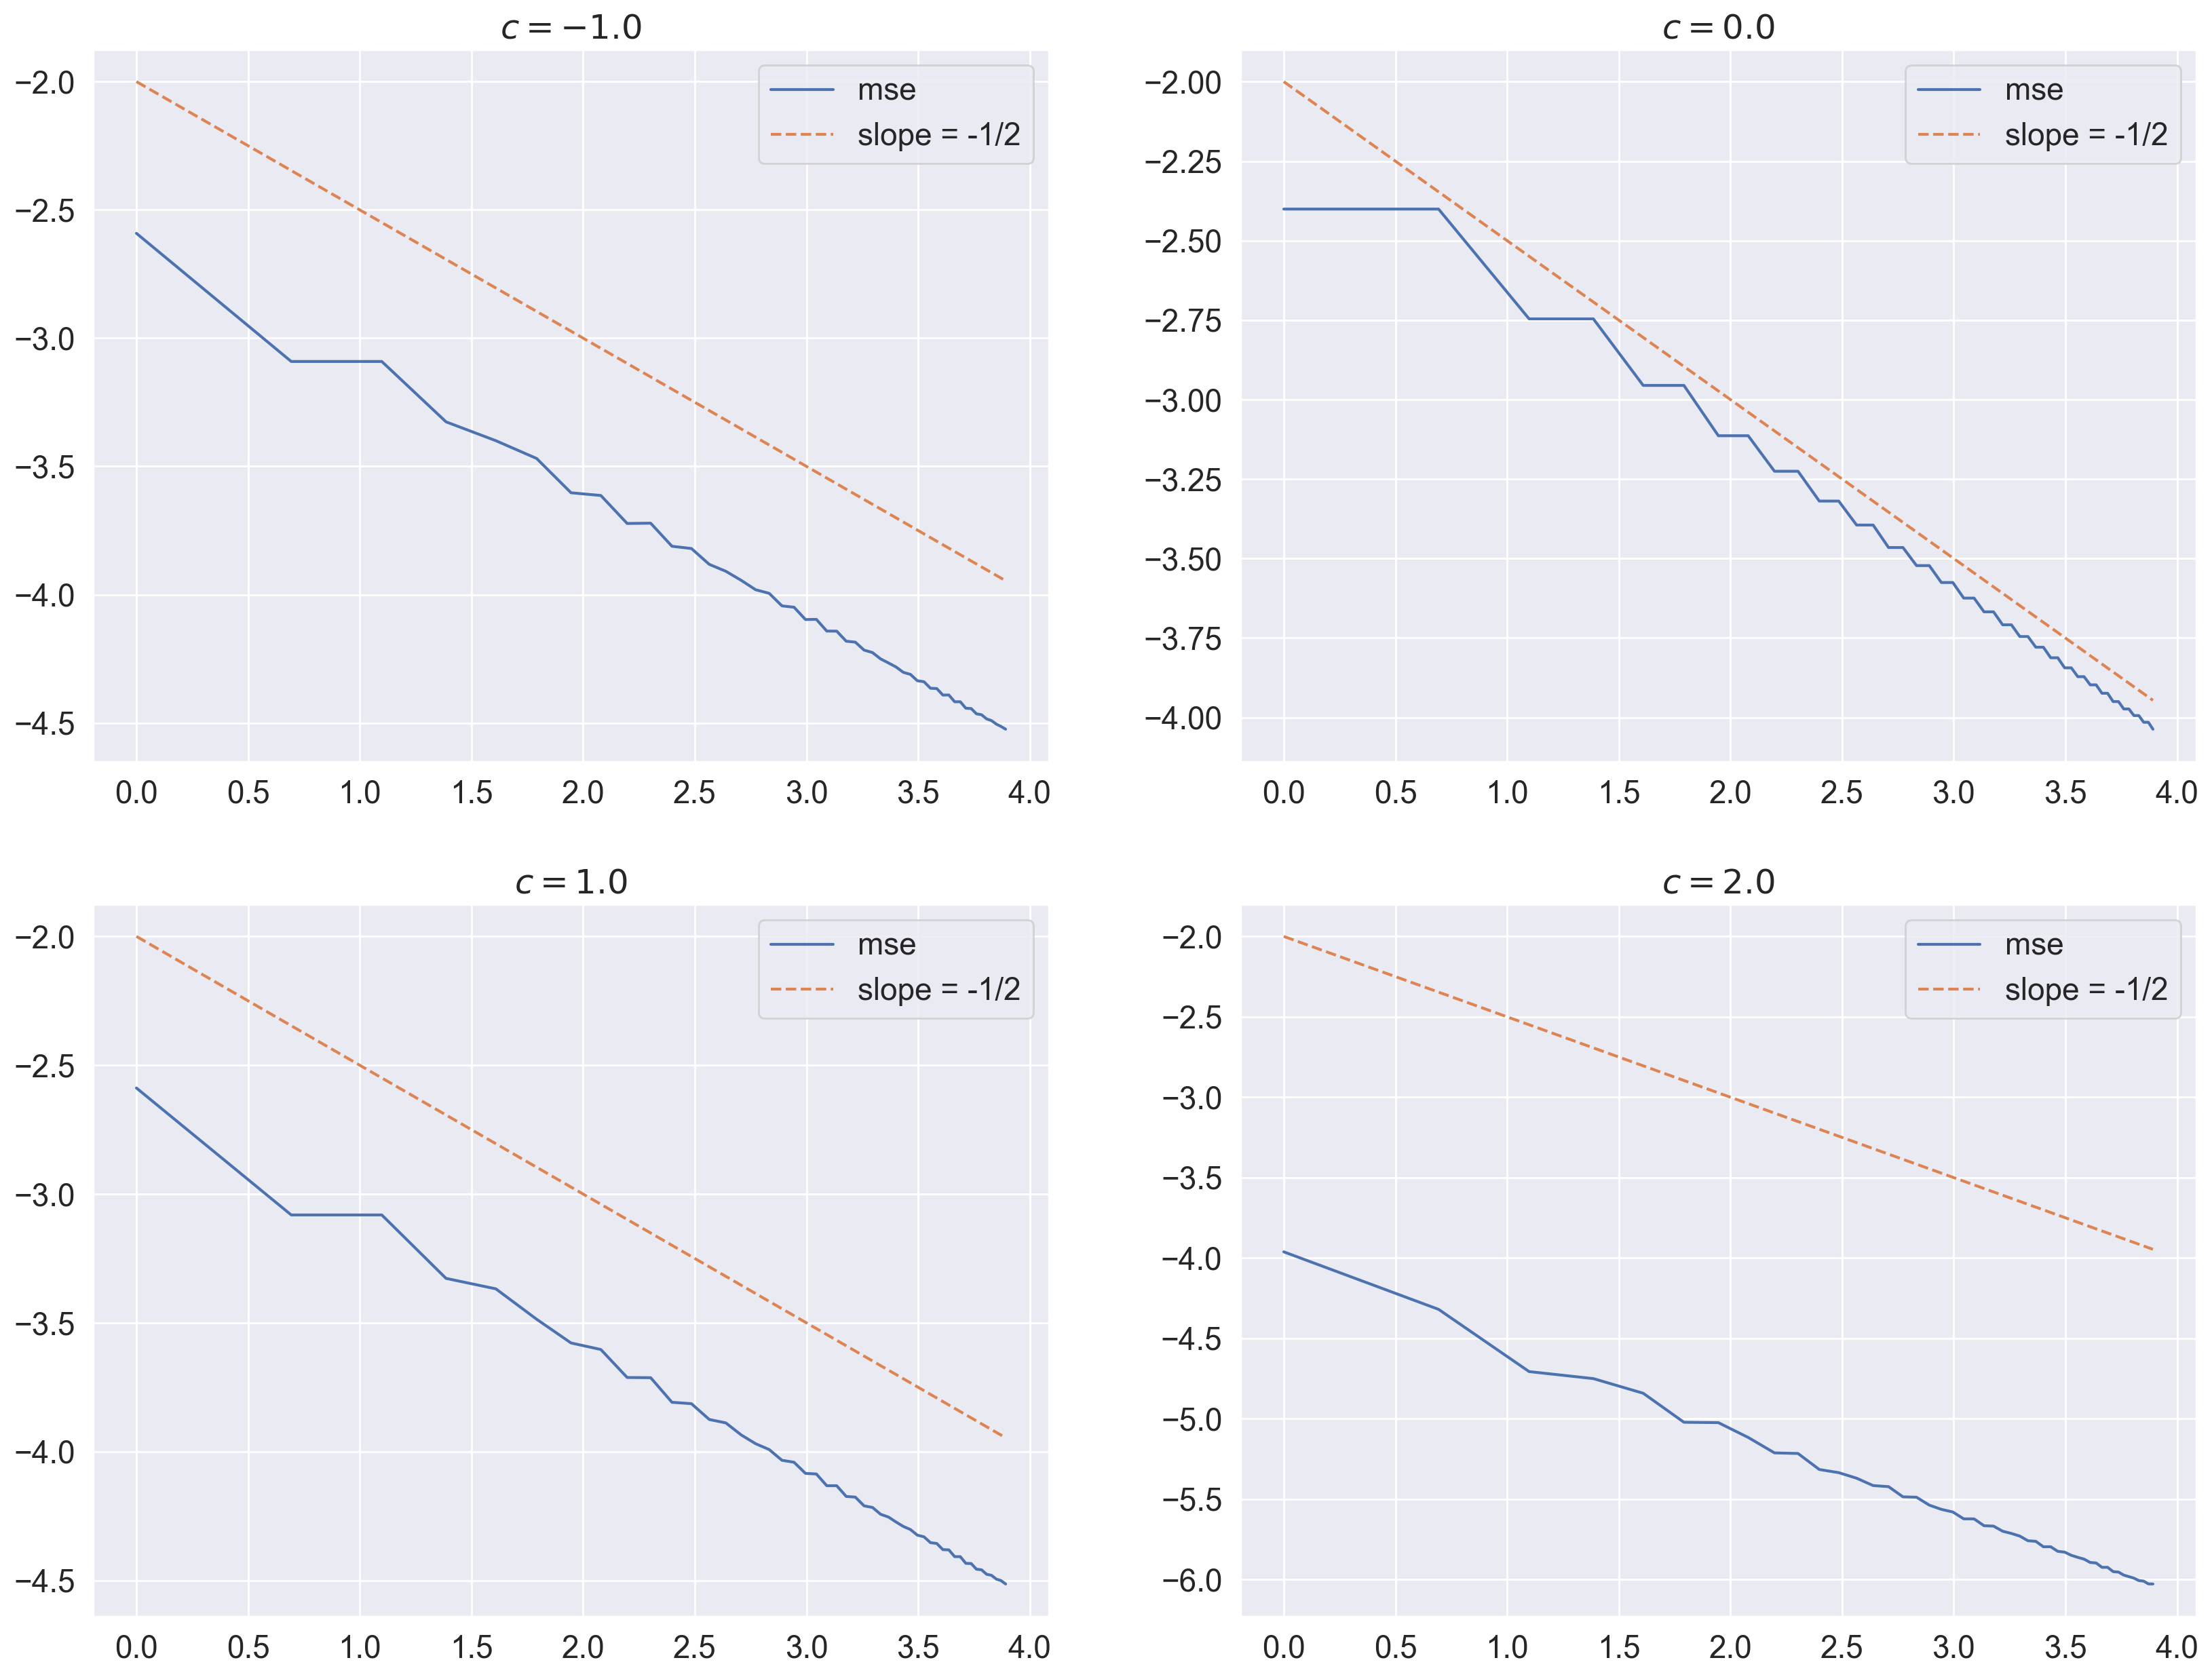

In [13]:
n_mc = 1 * 10**5
I_max = 50
tab_i = np.arange(1, I_max)
z = np.random.randn(n_mc)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

list_c = [-1.0, 0.0, 1.0, 2.0]
for c, ax in zip(list_c, axes, strict=True):
    print("c = ", c)
    mse_i = np.zeros(I_max - 1)
    for n in tab_i:
        ind_c = np.array([int(c <= x) for x in z])
        chaos = indicator_pce(c, z, n_pce=int(n))
        mse_i[n - 1] = np.mean((ind_c - chaos) ** 2)
    ax.plot(np.log(tab_i), np.log(mse_i), label="mse")
    ax.plot(
        np.log(tab_i), -0.5 * np.log(tab_i) - 2, linestyle="--", label="slope = -1/2"
    )
    ax.legend()
    ax.tick_params(axis="both", which="major")
    ax.set_title(f"$c = {c}$")
plt.show()

# 6. Study of the portfolio loss

Recall that the portfolio loss is given by

$$
\begin{align*}
    \mathcal{L} 
    &= \sum_{k=1}^{K} \ell_k \mathbf{1}_{a_k \varepsilon_k + b_k \leq \frac{\rho_k}{|\rho_k|} Z} \\
    &= \sum_{i=0}^{\infty} \left\{ \sum_{k=1}^{K} \ell_k \alpha_i (a_k \varepsilon_k + b_k)\frac{\rho_k^i}{|\rho_k|^i} \right\} \mathrm{He}_i(Z) \\
    &= \sum_{i=0}^{\infty} \varepsilon_{K,i} \, \mathrm{He}_i(Z) \\
\end{align*}
$$

We approximate the vector $(\varepsilon_{K,i})_{0 \leq i \leq I}$ 
with the Gaussian vector 
$(\varepsilon_{K,i}^G)_{0 \leq i \leq I} \sim \mathcal{N}(m_K, s_K)$
where $m_K = (m_{K,i})_{0 \leq i \leq I}$ and $s_K = (s_{K,i,j})_{0 \leq i,j \leq I}$.

- **Portfolio A (homogeneous portfolio)**

    $$
    \forall{k\in \{1,...,K\}}, 
    \quad p_k = p, \quad \rho_k = \rho, 
    \quad \ell_k = \frac{1}{\sqrt{k}}
    $$

- **Portfolio B (heterogeneous portfolio)**
    $$ 
    \forall k\in\{ 1,\dots, K\}, 
    \quad p_{k}=0.01\left(1+\sin\left(\frac{16\pi k}{K}\right)\right) + 0.001, 
    \quad \rho_k \sim U([0,1/\sqrt{10}])
    \quad \ell_{k}=\left(\left\lceil \frac{5k}{K}\right\rceil \right)^{2}, 
    $$

    Note in that case, the marginal default probabilities vary between $0\%$ 
    and $2\%$ with a mean $1\%$, and the losses $\ell_{k}$ are $1, 4, 9, 16, 25$ 
    with $K/5$ at each level.

In [41]:
# Set model parameters

n_obligors = 1 * 10**4  # number of obligors
range_k = np.arange(1, n_obligors + 1)
n_mc = 5 * 10**4  # number of simulations

portfolio = "B"

if portfolio == "A":
    p_k = 1e-2 * np.ones(n_obligors)  # default probability
    rho_k = 0.1 * np.ones(n_obligors)  # correlation
    loss_k = range_k ** (-0.5)  # loss given default
elif portfolio == "B":
    p_k = 1e-2 * (1 + np.sin((16.0 * np.pi * range_k) / n_obligors)) + 1e-3
    loss_k = np.ceil(5.0 * range_k / n_obligors) ** 2
    rho_k = np.random.uniform(0.0, 1.0 / np.sqrt(10.0), size=n_obligors) + 1e-3
else:
    raise ValueError("Unknown portfolio")

b_k = -stats.norm.ppf(p_k) / np.abs(rho_k)  # mean
a_k = -np.sqrt(1.0 - rho_k**2) / np.abs(rho_k)  # variance

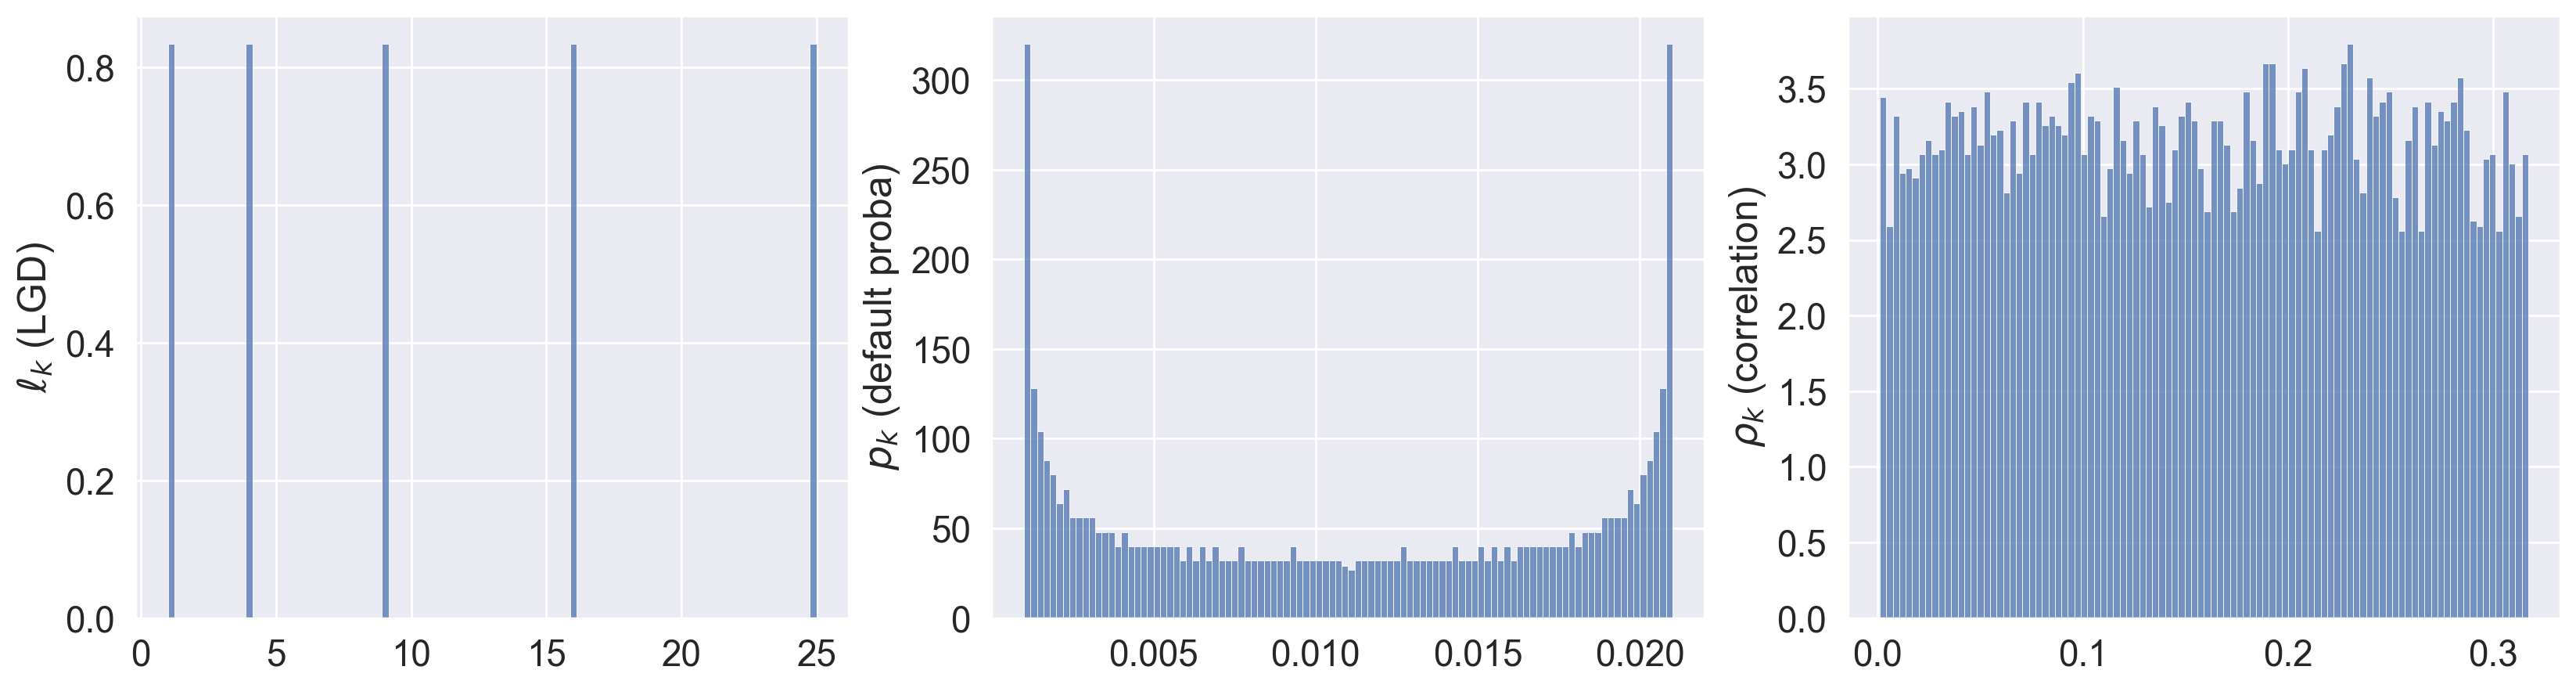

In [42]:
# Plot model parameters
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.histplot(loss_k, kde=False, stat="density", ax=ax1, bins=100)
ax1.set_ylabel("$\\ell_k$ (LGD)")
ax1.tick_params(axis="both", which="major")

sns.histplot(p_k, kde=False, stat="density", ax=ax2, bins=100)
ax2.set_ylabel("$p_k$ (default proba)")
ax2.tick_params(axis="both", which="major")

sns.histplot(rho_k, kde=False, stat="density", ax=ax3, bins=100)
ax3.set_ylabel("$\\rho_k$ (correlation)")
ax3.tick_params(axis="both", which="major")

plt.show()

## 6.1 Study of the vector $(\varepsilon_{K,i})_{0 \leq i \leq I}$

Histograms of $\varepsilon_{K,i}$ and kde plot of $\varepsilon_{K,i}^G$
for $i\in \{1,3,6,9\}$.

In [43]:
range_n_pce = [1, 3, 6, 9]  # different orders of PCE

In [44]:
n_pce = range_n_pce[-1]
mean_coef = mean_indicator_pce(n=n_pce, a=a_k, b=b_k)
# we neeed to compute the covariance matrix up to 2 * n_pce
cov_coef = cov_indicator_pce(n=2 * n_pce, a=a_k, b=b_k)
cov_coef = cov_coef[: n_pce + 1, : n_pce + 1]

In [45]:
print(f"Shape of mean_coef: {mean_coef.shape}")  # shape is (n_pce+1, n_obligors)
print(f"Shape of cov_coef: {cov_coef.shape}")  # shape is (n_pce+1, n_pce+1, n_obligors)

Shape of mean_coef: (10, 10000)
Shape of cov_coef: (10, 10, 10000)


In [46]:
mean_eps = np.sum(mean_coef * loss_k[None, :], axis=1)
cov_eps = np.sum(cov_coef * (loss_k**2)[None, None, :], axis=2)

In [47]:
print(f"Shape of mean_eps: {mean_eps.shape}")  # shape is (n_pce+1,)
print(f"Shape of cov_eps: {cov_eps.shape}")  # shape is (n_pce+1, n_pce+1)

Shape of mean_eps: (10,)
Shape of cov_eps: (10, 10)


In [ ]:
try:
    chol_cov_eps = np.linalg.cholesky(cov_eps)
except np.linalg.LinAlgError:
    print("Cholesky failed, using SVD-based fallback.")
    chol_cov_eps = cholesky_from_svd(cov_eps)
except:
    raise ValueError("Cholesky decomposition failed.")

np.random.seed(SEED)
z = np.random.randn(n_pce + 1, n_mc)
eps_normal_approx = mean_eps[:, None] + chol_cov_eps @ z

In [49]:
# Use loop to compute the PCE
n_loop = 10
n_mc_loop = n_mc // n_loop

In [50]:
np.random.seed(SEED)

# Initialize lists to collect results for each PCE order
eps_lists = [[] for _ in range(len(range_n_pce))]

# Simulate and collect results for each loop and PCE order
for j in range(n_loop):
    print(f"loop: {j + 1}/{n_loop}")
    normal = np.random.randn(n_obligors, n_mc_loop)
    for idx, i in enumerate(range_n_pce):
        eps_i = np.sum(
            loss_k[:, None]
            * coef_indicator_pce(n=i, x=a_k[:, None] * normal + b_k[:, None]),
            axis=0,
        )
        eps_lists[idx].append(eps_i)


for i in range(len(range_n_pce)):
    eps_lists[i] = np.array(eps_lists[i]).reshape(-1, 1)

loop: 1/10
loop: 2/10
loop: 3/10
loop: 4/10
loop: 5/10
loop: 6/10
loop: 7/10
loop: 8/10
loop: 9/10
loop: 10/10


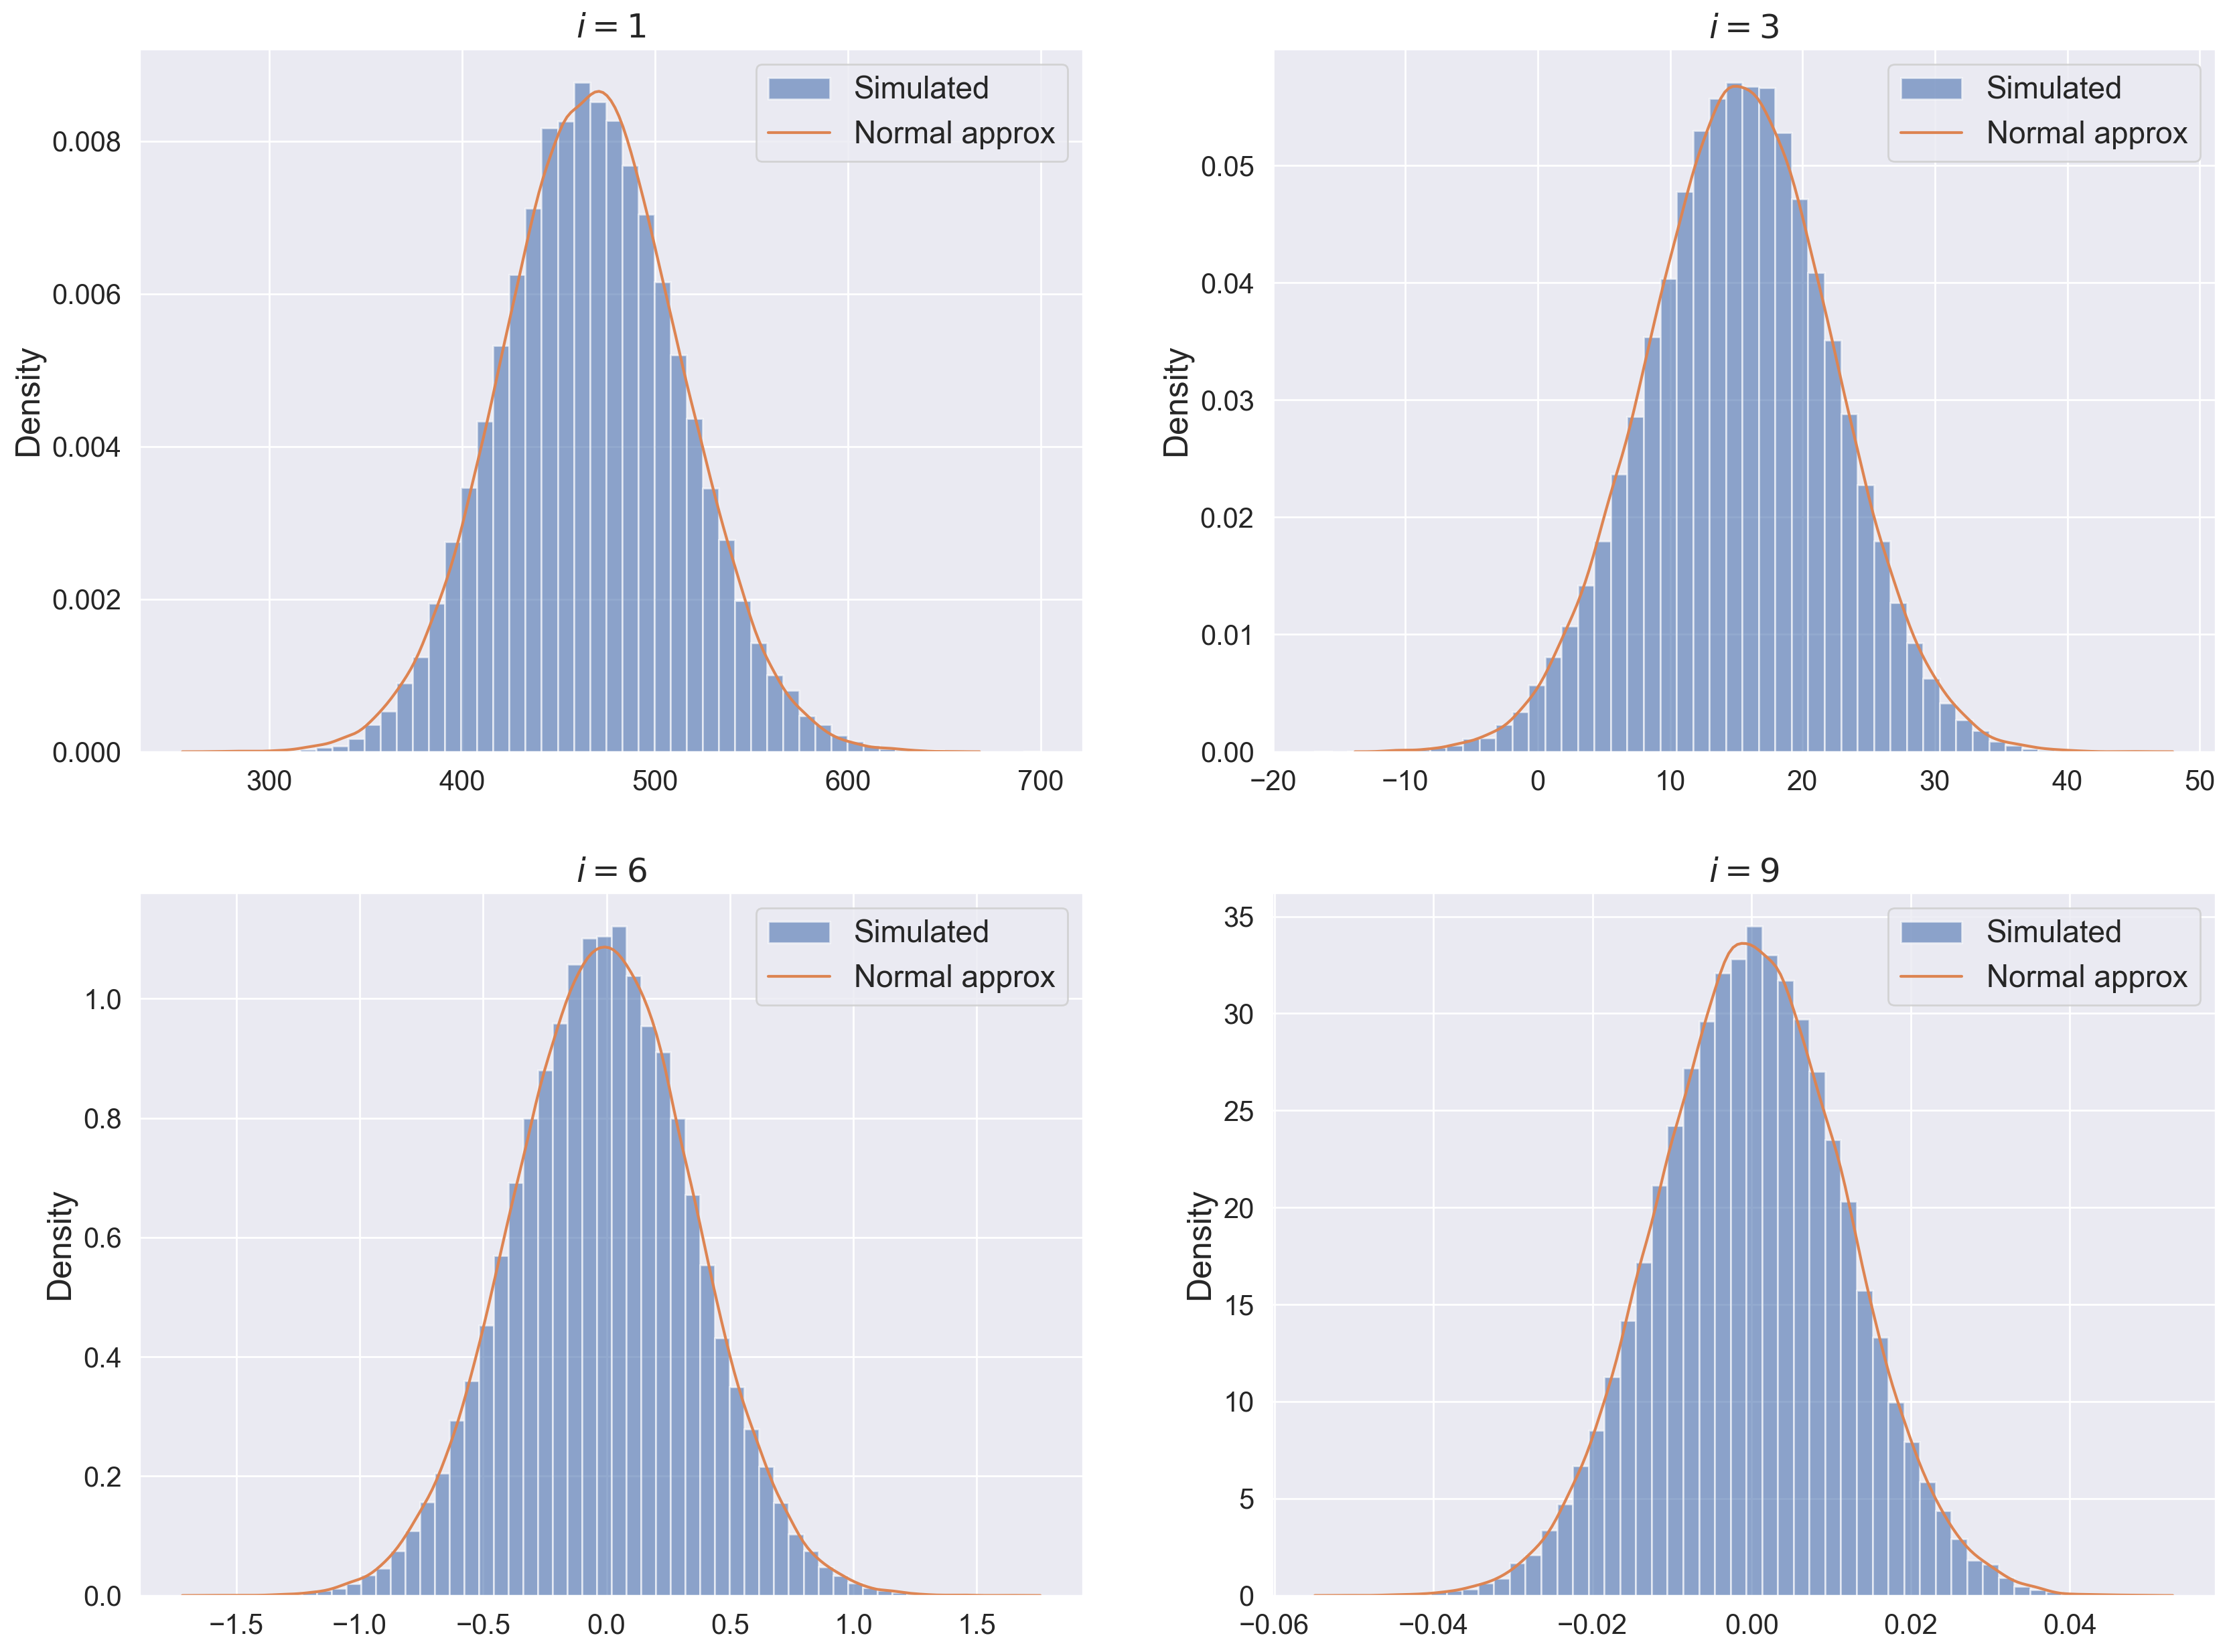

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for j, ax in zip(range(4), axes, strict=True):
    i = range_n_pce[j]
    # Plot the histogram of the simulated epsilon values
    ax.hist(
        eps_lists[j],
        bins=50,
        density=True,
        alpha=0.6,
        # color="blue",
        label="Simulated",
    )
    # Plot KDE of the normal approximation
    sns.kdeplot(eps_normal_approx[i, :].flatten(), ax=ax, label="Normal approx")
    ax.set_title(f"$i = {range_n_pce[j]}$")
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.legend()
plt.show()

## 6.2 Kernel density estimation of $\mathcal{L}$ and $\mathcal{L}_{I}^{G}$ conditionally on $Z \in \{-1,0,1,2\}$

In [52]:
np.random.seed(SEED)
list_z = [-1.0, 0.0, 1.0, 2.0]

loss_cond_lists = [[] for _ in range(len(range_n_pce))]
for j in range(n_loop):
    print(f"loop: {j + 1}/{n_loop}")
    normal = np.random.randn(n_obligors, n_mc_loop)
    for i in range(len(range_n_pce)):
        loss_cond_z_i = np.sum(
            loss_k[:, None] * 1.0 * (a_k[:, None] * normal + b_k[:, None] < list_z[i]),
            axis=0,
        )
        loss_cond_lists[i].append(loss_cond_z_i)

for i in range(len(range_n_pce)):
    loss_cond_lists[i] = np.array(loss_cond_lists[i]).reshape(-1, 1)

loop: 1/10
loop: 2/10
loop: 3/10
loop: 4/10
loop: 5/10
loop: 6/10
loop: 7/10
loop: 8/10
loop: 9/10
loop: 10/10


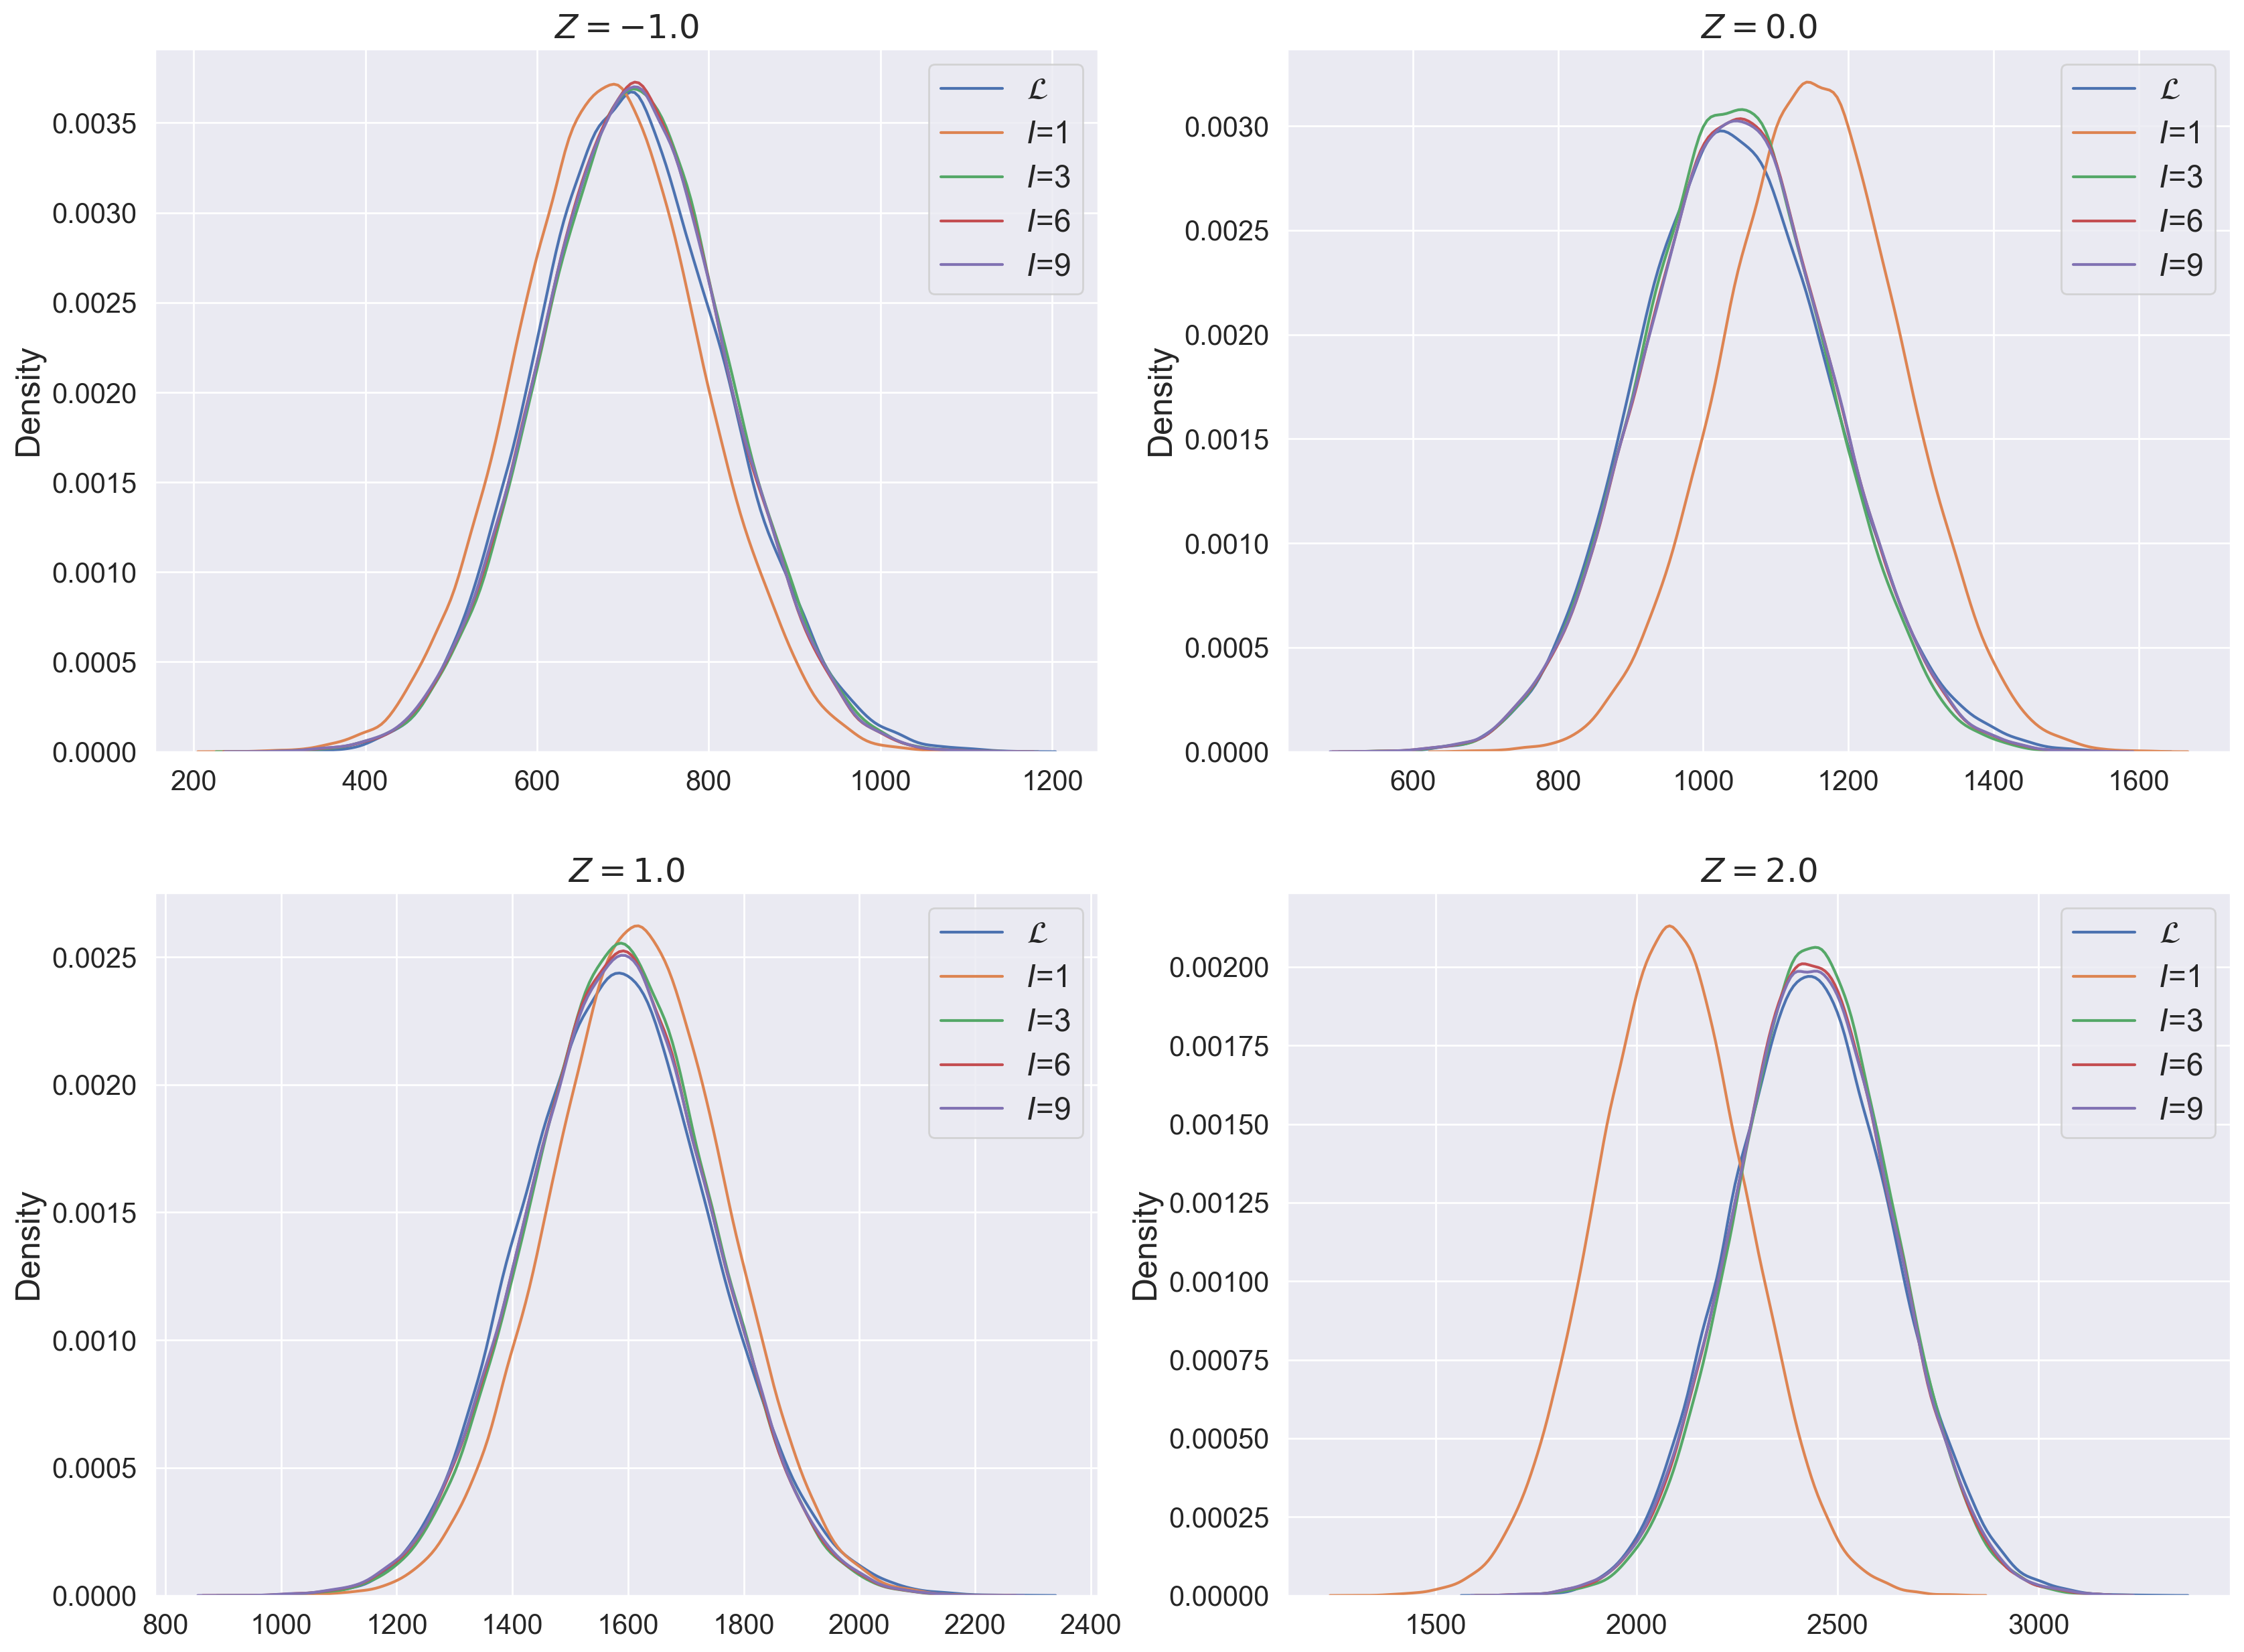

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
for j, ax in zip(range(4), axes, strict=True):
    # Loss conditional on Z
    sns.kdeplot(loss_cond_lists[j], ax=ax, label=r"$\mathcal{L}$")

    # PCE approximation
    hermite_pce = np.array(
        [special.hermitenorm(m)(list_z[j]) for m in range(n_pce + 1)]
    )
    for i in range_n_pce:
        loss_normal_approx_cond = np.sum(
            eps_normal_approx[: (i + 1), :] * hermite_pce[: (i + 1), None], axis=0
        )
        sns.kdeplot(loss_normal_approx_cond, ax=ax, label=f"$I$={i}")

    ax.set_title(f"$Z = {list_z[j]}$")
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.legend()
plt.show()

## 6.3 Kernel density estimation of $\mathcal{L}$ and $\mathcal{L}_{I}^{G}$

In [62]:
np.random.seed(SEED)
loss = np.zeros((n_mc_loop, n_loop))
for j in range(n_loop):
    print(f"loop: {j + 1}/{n_loop}")
    normal = np.random.randn(n_obligors, n_mc_loop)
    z = np.random.randn(n_mc_loop)
    loss[:, j] = np.sum(
        loss_k[:, None] * 1.0 * (a_k[:, None] * normal + b_k[:, None] < z[None, :]),
        axis=0,
    )
loss = np.array(loss).reshape(-1, 1)

loop: 1/10
loop: 2/10
loop: 3/10
loop: 4/10
loop: 5/10
loop: 6/10
loop: 7/10
loop: 8/10
loop: 9/10
loop: 10/10


In [ ]:
np.random.seed(SEED + 1)
loss_normal_approx = np.zeros((len(range_n_pce), n_mc))
z = np.random.randn(n_mc)
hermite_pce = np.array([special.hermitenorm(m)(z) for m in range(n_pce + 1)])
for i, n in enumerate(range_n_pce):
    loss_normal_approx[i, :] = np.sum(
        eps_normal_approx[: (n + 1), :] * hermite_pce[: (n + 1), :], axis=0
    )

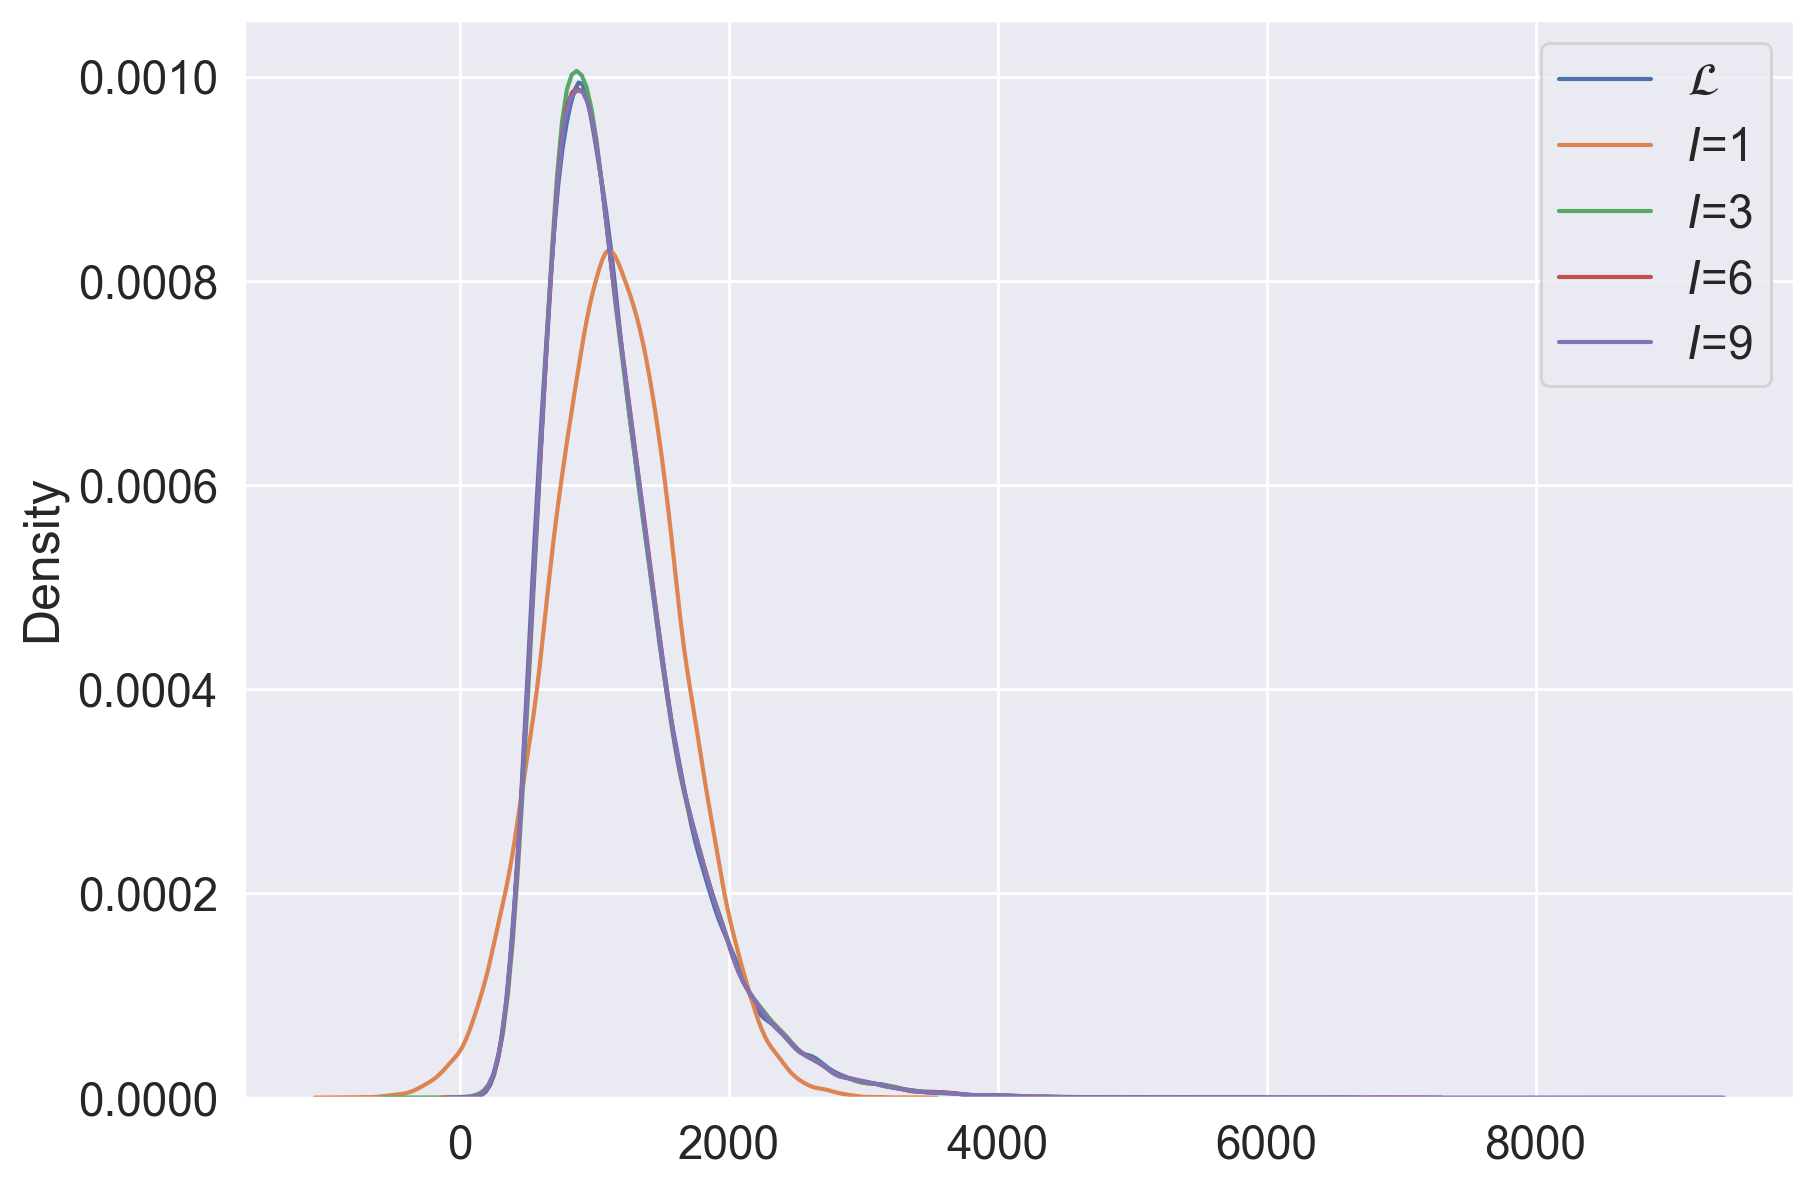

In [91]:
fig, ax = plt.subplots(figsize=(10, 7))
# Portfolio loss
sns.kdeplot(loss, ax=ax, label=r"$\mathcal{L}$")
# PCE approximation
for i, n in enumerate(range_n_pce):
    sns.kdeplot(loss_normal_approx[i], ax=ax, label=f"$I$={n}")
ax.legend()
plt.show()

## 6.4 Q-Q plot

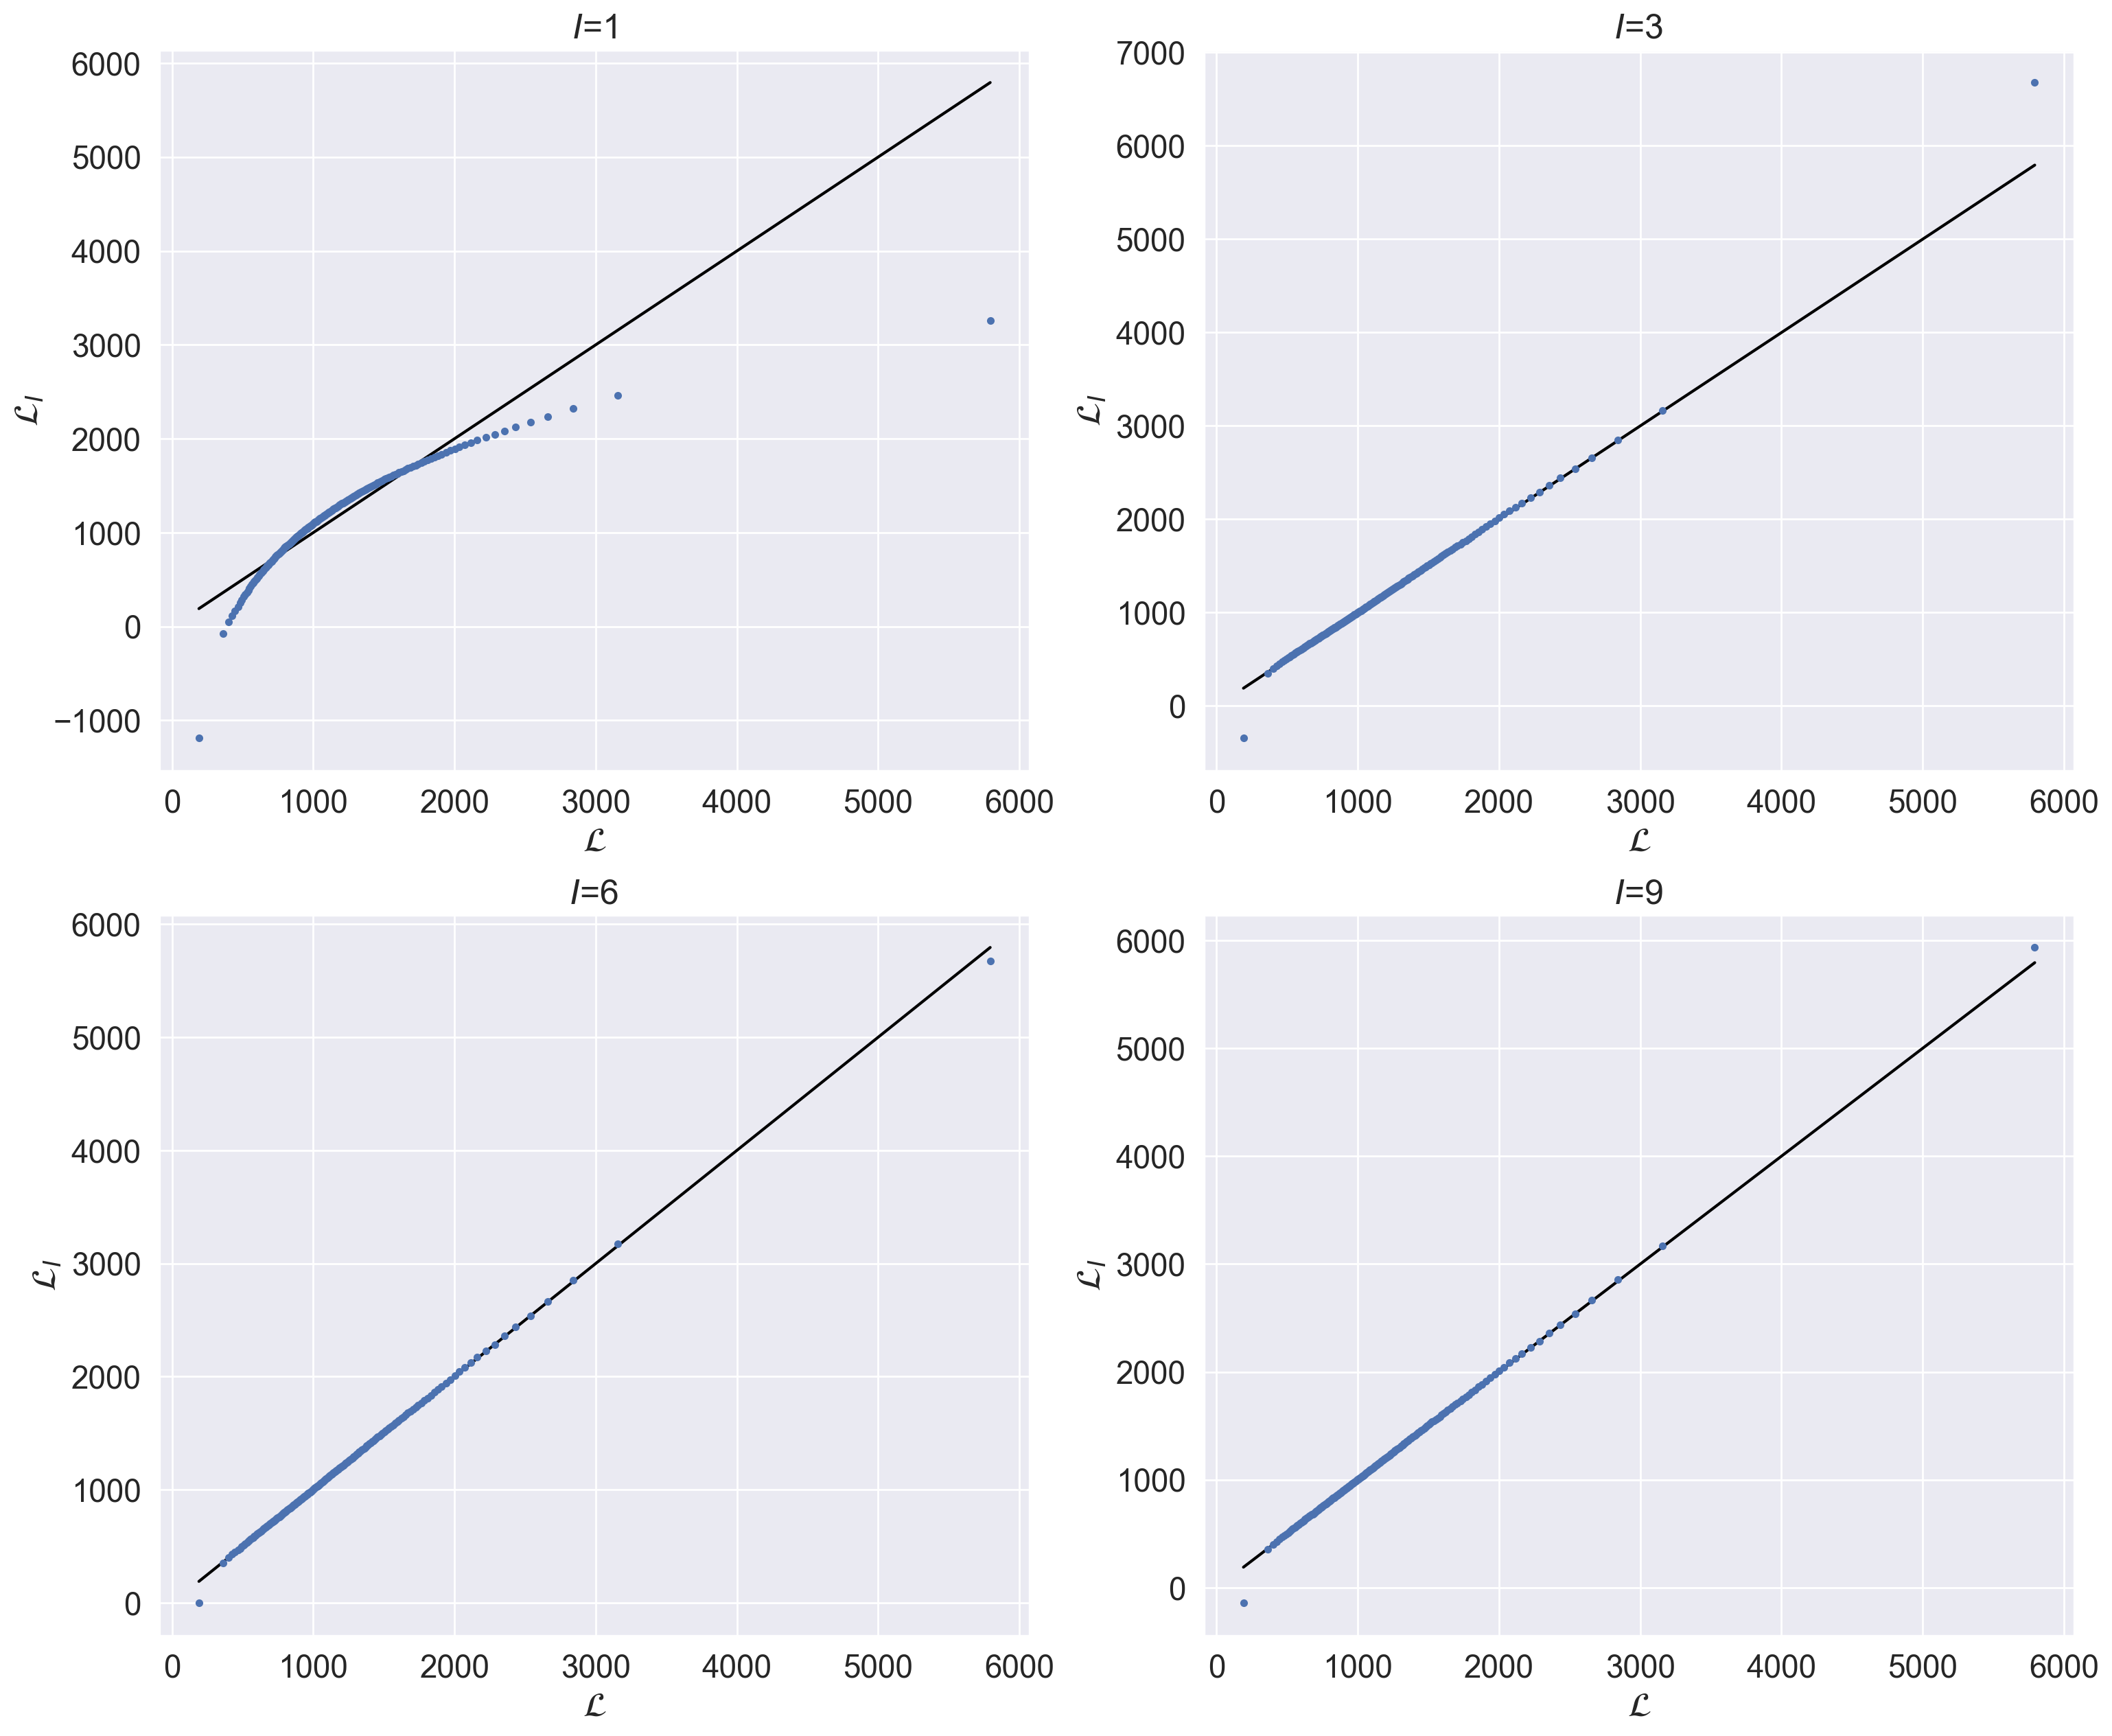

In [ ]:
q = np.linspace(0.0, 100.0, 200)  # percentiles

fig, axes = plt.subplots(2, 2, figsize=(18, 15))
axes = axes.flatten()
q_loss = np.percentile(loss, q=q)
for i, ax in zip(range(4), axes, strict=True):
    q_loss_approx = np.percentile(list_loss_normal_approx[i], q=q)
    ax.plot(q_loss, q_loss, linestyle="-", color="black")
    ax.plot(q_loss, q_loss_approx, ".")
    ax.set_title(f"$I$={range_n_pce[i]}")
    ax.set_xlabel(r"$\mathcal{L}$")
    ax.set_ylabel(r"$\mathcal{L}_{I}$")
plt.show()